In [1]:
import os
import pandas as pd
import numpy as np
import math
import seaborn as sns
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from dateutil import parser
import io
import base64
from IPython.display import HTML
from imblearn.under_sampling import RandomUnderSampler
%matplotlib inline

In [2]:
chunk_size = 100000

chunk_num_train = pd.read_csv("../../data/train_numeric.csv",     chunksize = chunk_size)
chunk_dat_train = pd.read_csv("../../data/train_date.csv"   ,     chunksize = chunk_size)
chunk_cat_train = pd.read_csv("../../data/train_categorical.csv", chunksize = chunk_size)

df_num_train = chunk_num_train.get_chunk(chunk_size)
df_dat_train = chunk_dat_train.get_chunk(chunk_size)
df_cat_train = chunk_cat_train.get_chunk(chunk_size)

C:\Users\Tomonobu\Anaconda3\lib\site-packages\ipykernel\zmqshell.py:533: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,41,42,43,44,45,46,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,188,189,190,191,192,193,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,324,335,337,340,342,344,346,348,351,354,357,360,363,366,369,372,375,378,381,384,387,390,393,396,399,402,

In [3]:
df_num_train.shape

(100000, 970)

 
OKデータをアンダーサンプリングする

In [4]:
df_num_ok = df_num_train[df_num_train['Response'] == 0]
df_num_ng = df_num_train[df_num_train['Response'] == 1]

undersample_rate = len(df_num_ng) * 3 / len(df_num_ok)
df_num_ok_sample = df_num_ok.sample(frac = undersample_rate)

df_num_balance = pd.concat([df_num_ok_sample, df_num_ng])
print('Response = 0のテーブル', df_num_ok.shape)
print('Response = 1のテーブル', df_num_ng.shape)
print('Response = 0をアンダーサンプルした後のフレーム', df_num_balance.shape)

Response = 0のテーブル (99432, 970)
Response = 1のテーブル (568, 970)
Response = 0をアンダーサンプルした後のフレーム (2272, 970)


カテゴリカルデータも対応するIDだけ残す

In [5]:
df_ids = df_num_balance.loc[:, ['Id', 'Response']]
df_cat_balance = pd.merge(df_ids, df_cat_train, on=['Id'], how = 'left')
df_cat_balance.head()


,Id,Response,L0_S1_F25,L0_S1_F27,L0_S1_F29,L0_S1_F31,L0_S2_F33,L0_S2_F35,L0_S2_F37,L0_S2_F39,...,L3_S49_F4225,L3_S49_F4227,L3_S49_F4229,L3_S49_F4230,L3_S49_F4232,L3_S49_F4234,L3_S49_F4235,L3_S49_F4237,L3_S49_F4239,L3_S49_F4240
0,42975,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,190582,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10972,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,30081,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,166084,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# 全部 NaN な列をdropして、Nanを大きな値で置換。
print("before" + str(df_num_balance.shape))
df_num_balance.dropna(how='all', axis=1, inplace=True)
df_num_balance.fillna(999, inplace=True)
print("after" + str(df_num_balance.shape))

before(2272, 970)
after(2272, 962)


In [7]:
# 全部 NaN な列をdropして、Nanを大きな値で置換。
print("before" + str(df_cat_train.shape))
df_cat_balance.dropna(how='all', axis=1, inplace=True)
df_cat_balance.fillna(999, inplace=True)
print("after" + str(df_cat_train.shape))

before(100000, 2141)
after(100000, 2141)


In [8]:
# カテゴリ変数のパース(仮実装で、値に変換するだけ)
# 最終的にはビットマップっぽいので、エンコーディングする。
from parse import *
def cat_data_to_val(x):
    if type(x) is str:
        r = parse("T{}", x)
        return float(r[0])
    else:
        return x


In [9]:

def is_bit_on(s, pos):
    if type(s) is str:
        r = parse("T{}", s)
        val = (int(r[0]))
        mask = 1 << pos
        if val & mask:
            return 1
        else:
            return 0
    else:
        return 0

In [10]:
def decode_categorical_data(df):
    for column_name, item in df.iteritems():
        if column_name == 'Id':
            continue
        if column_name == 'Response':
            continue
        print(column_name)
        vallist = item.unique()
        bitlist = []
        for c in vallist:
            if type(c) is str:
                r = parse("T{}", c)
                val = int(r[0])
                if val < 0:
                    val = val + 4294967296
                bitpos = int(np.log2(val))
                bitlist.append(bitpos)

        for bit in bitlist:
            df[column_name + "_bit_" + str(bit)] = df[column_name].apply(lambda x:is_bit_on(x, bit)).astype('int8')
        df.drop(column_name, axis=1, inplace=True)

    

In [11]:
df_cat_balance.shape

(2272, 630)

In [12]:

decode_categorical_data(df_cat_balance)
print(df_cat_balance['Response'].values)

L0_S2_F33
L0_S2_F35
L0_S2_F37
L0_S2_F39
L0_S2_F41
L0_S2_F43
L0_S2_F45
L0_S2_F47
L0_S2_F49
L0_S2_F51
L0_S2_F53
L0_S2_F55
L0_S2_F57
L0_S2_F59
L0_S2_F61
L0_S2_F63
L0_S2_F65
L0_S2_F67
L0_S4_F105
L0_S4_F107
L0_S4_F108
L0_S4_F110
L0_S4_F113
L1_S24_F675
L1_S24_F695
L1_S24_F698
L1_S24_F703
L1_S24_F705
L1_S24_F708
L1_S24_F710
L1_S24_F713
L1_S24_F717
L1_S24_F722
L1_S24_F726
L1_S24_F731
L1_S24_F736
L1_S24_F740
L1_S24_F744
L1_S24_F749
L1_S24_F754
L1_S24_F759
L1_S24_F764
L1_S24_F769
L1_S24_F773
L1_S24_F778
L1_S24_F783
L1_S24_F788
L1_S24_F793
L1_S24_F798
L1_S24_F817
L1_S24_F819
L1_S24_F820
L1_S24_F821
L1_S24_F823
L1_S24_F824
L1_S24_F825
L1_S24_F827
L1_S24_F828
L1_S24_F830
L1_S24_F832
L1_S24_F833
L1_S24_F835
L1_S24_F837
L1_S24_F838
L1_S24_F840
L1_S24_F842
L1_S24_F843
L1_S24_F845
L1_S24_F847
L1_S24_F848
L1_S24_F849
L1_S24_F851
L1_S24_F852
L1_S24_F853
L1_S24_F855
L1_S24_F856
L1_S24_F858
L1_S24_F860
L1_S24_F861
L1_S24_F863
L1_S24_F865
L1_S24_F866
L1_S24_F868
L1_S24_F870
L1_S24_F871
L1_S24_F873
L1_S24_F8

[ 42975 190582  10972 ..., 196987 198222 199312] [0 0 0 ..., 1 1 1]


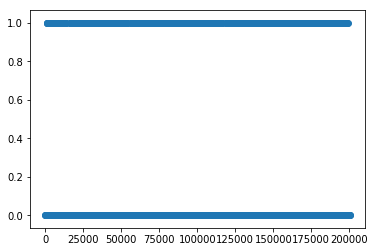

[0 0 0 ..., 1 1 1] [0 0 0 ..., 1 1 1]


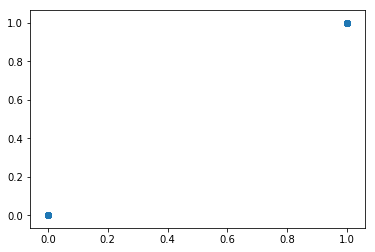

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


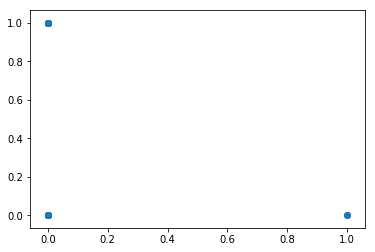

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


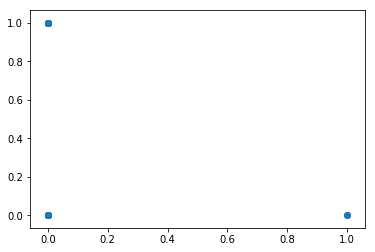

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


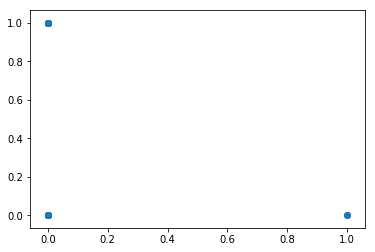

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


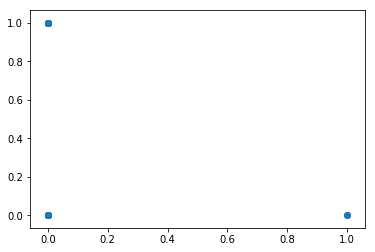

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


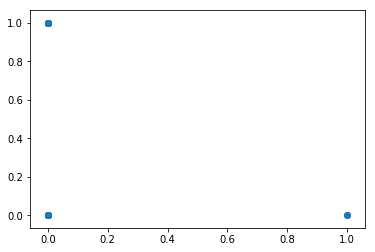

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


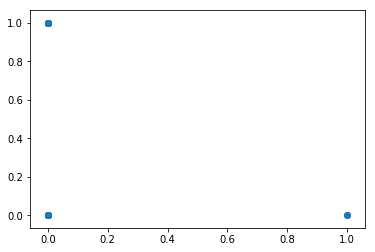

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


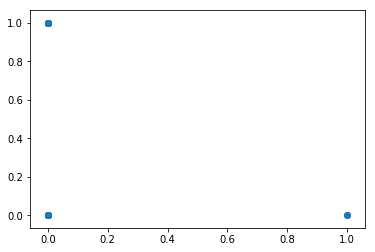

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


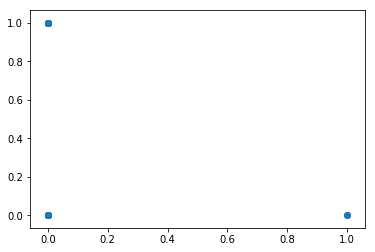

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


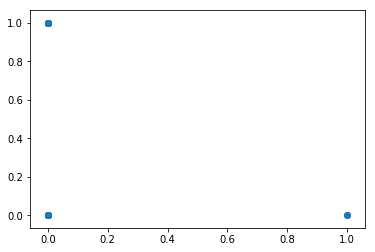

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


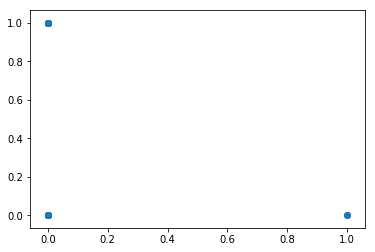

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


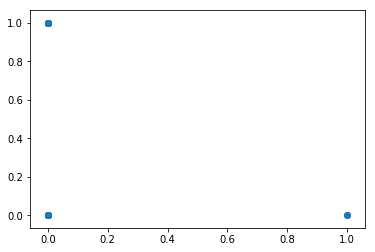

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


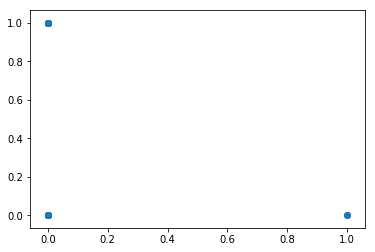

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


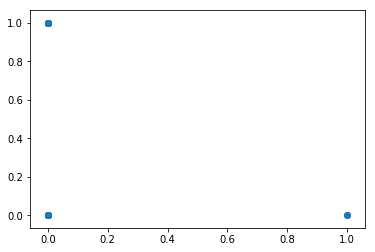

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


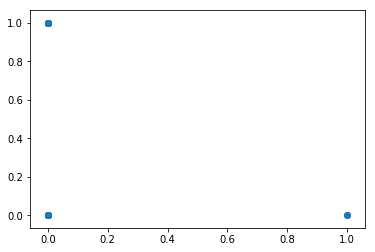

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


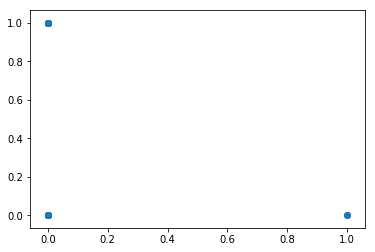

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


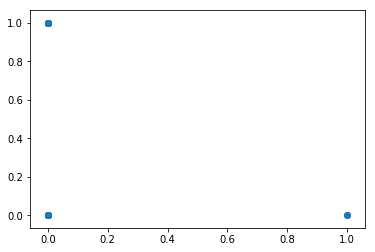

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


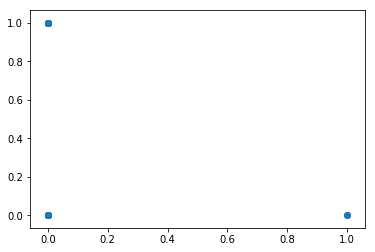

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


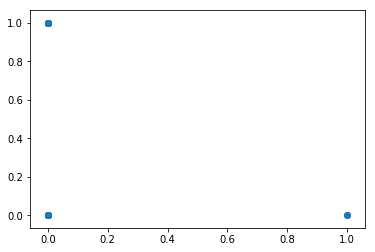

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


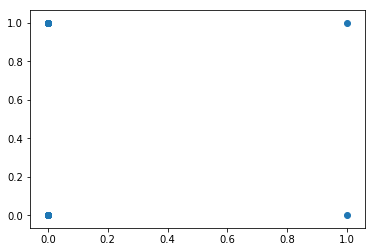

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


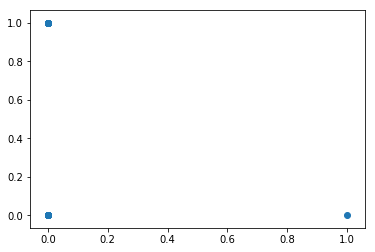

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


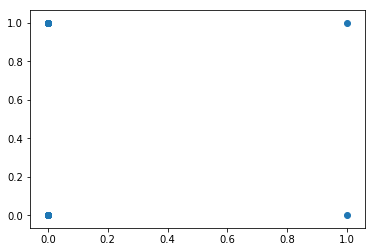

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


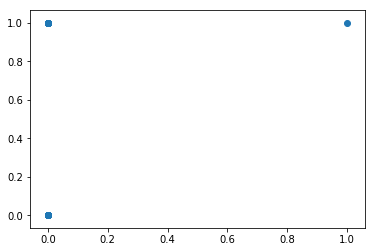

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


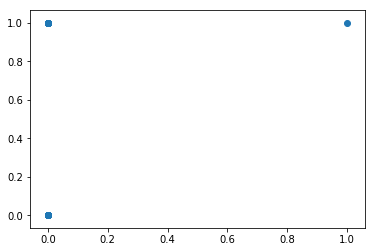

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


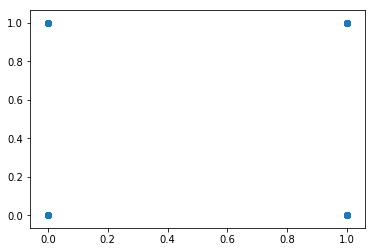

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


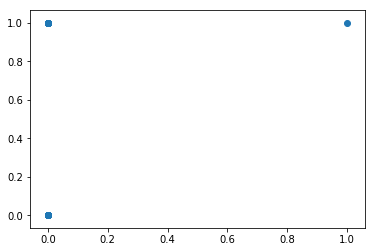

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


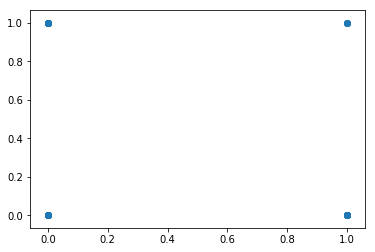

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


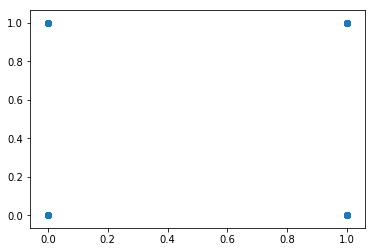

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


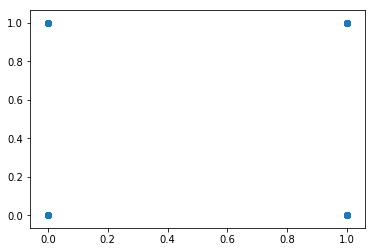

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


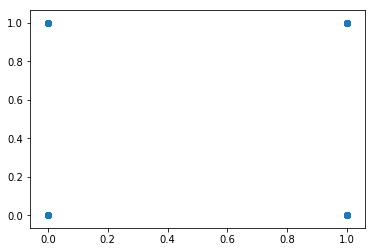

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


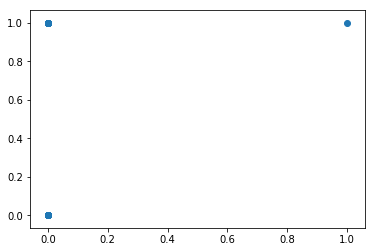

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


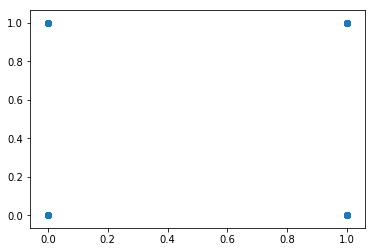

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


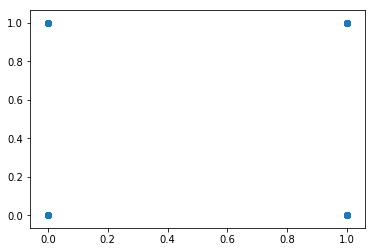

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


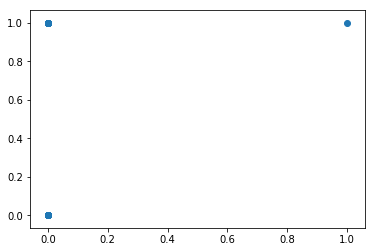

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


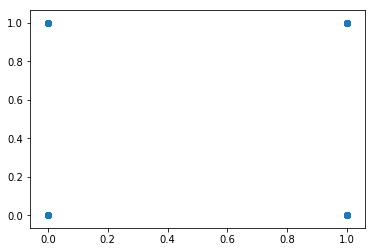

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


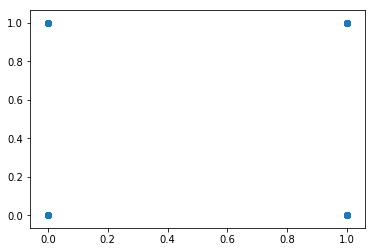

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


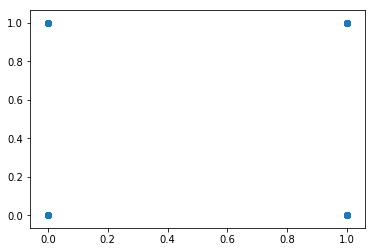

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


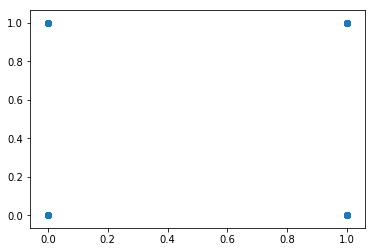

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


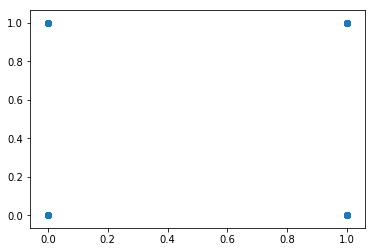

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


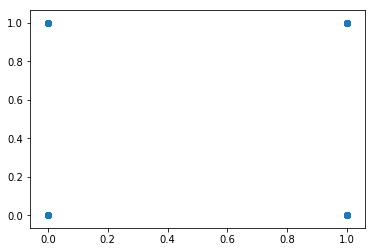

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


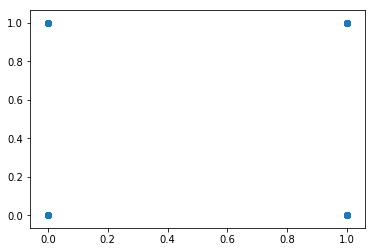

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


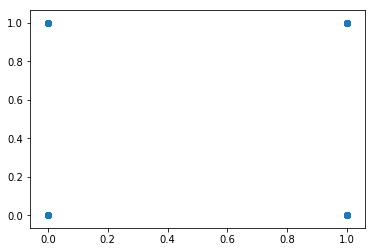

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


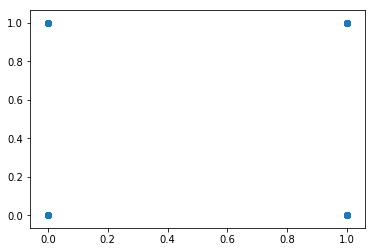

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


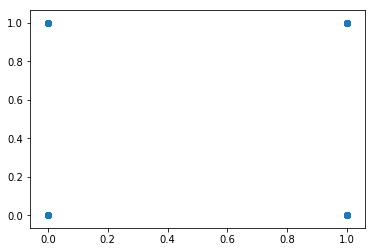

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


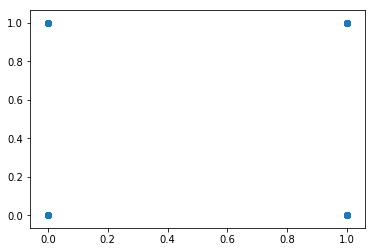

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


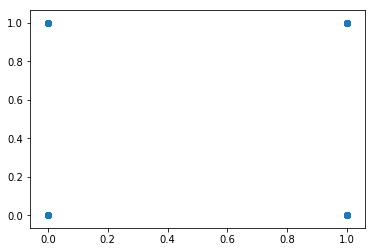

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


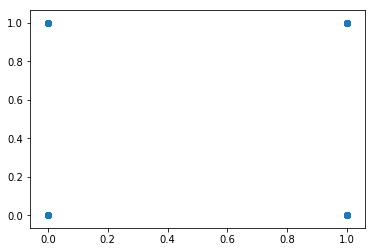

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


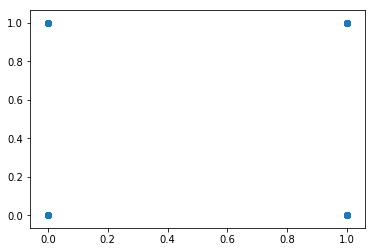

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


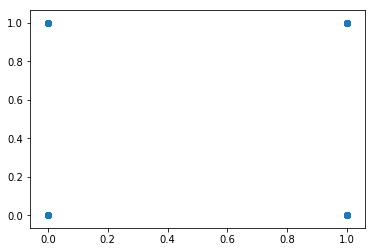

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


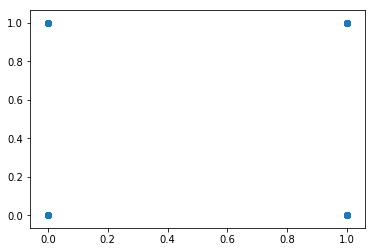

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


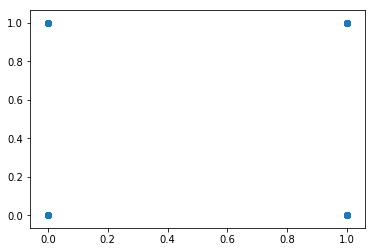

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


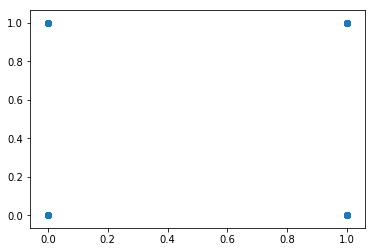

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


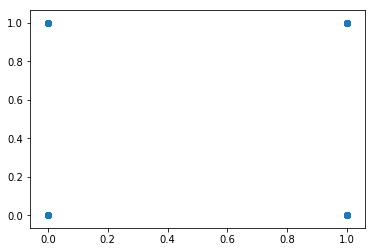

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


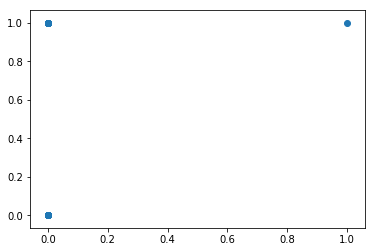

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


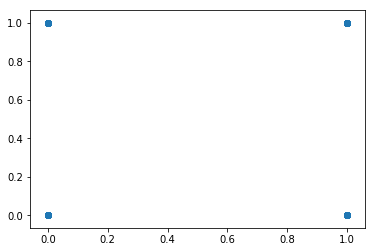

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


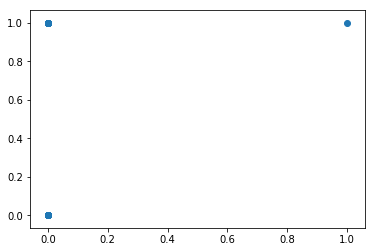

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


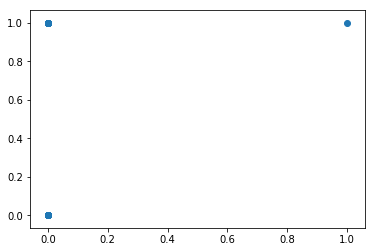

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


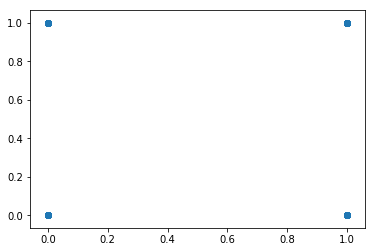

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


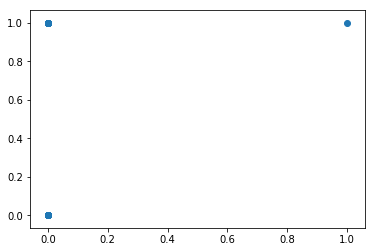

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


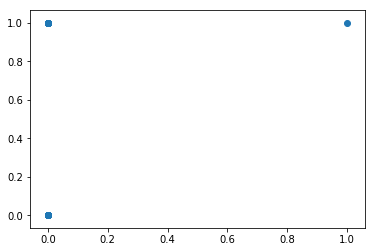

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


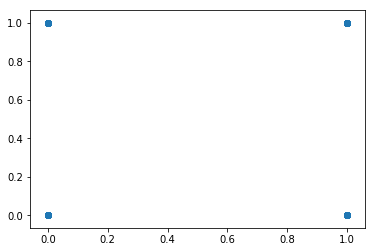

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


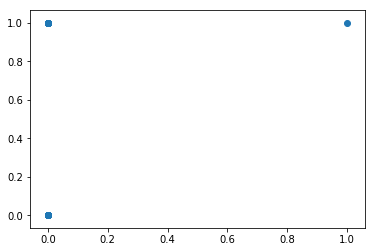

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


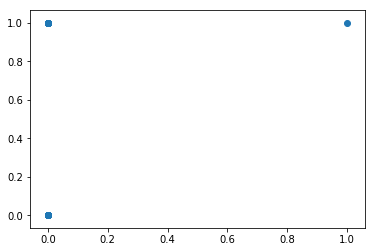

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


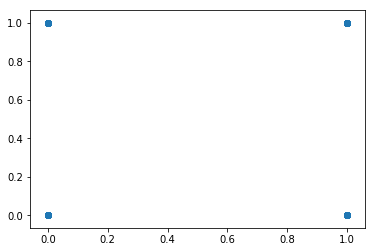

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


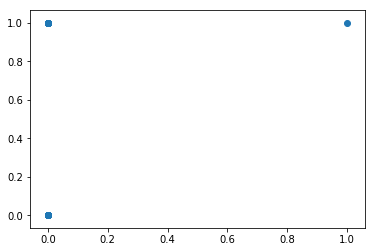

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


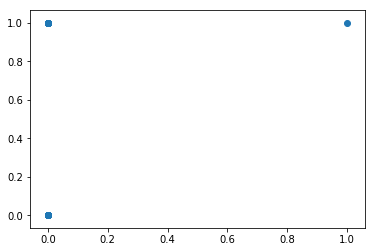

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


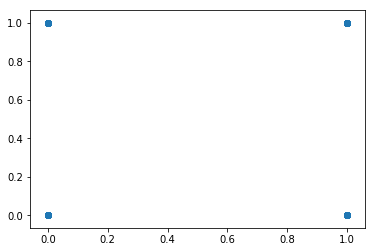

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


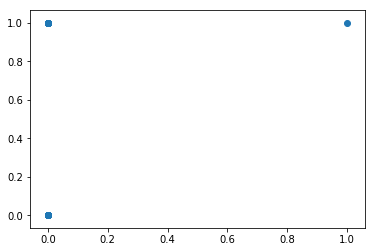

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


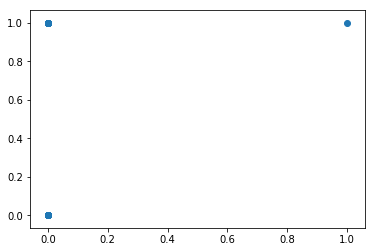

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


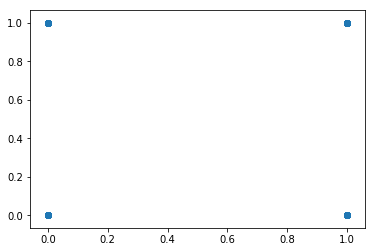

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


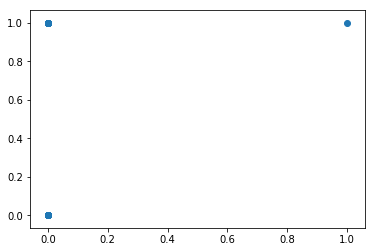

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


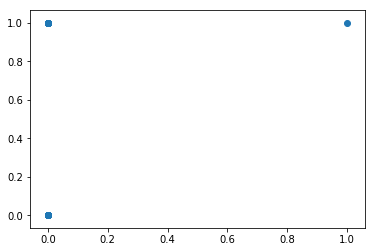

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


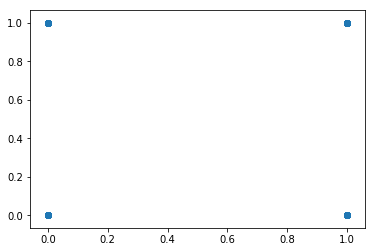

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


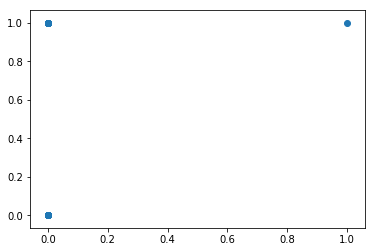

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


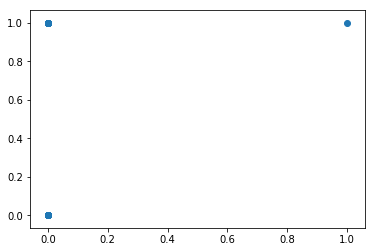

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


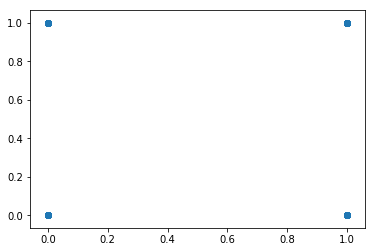

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


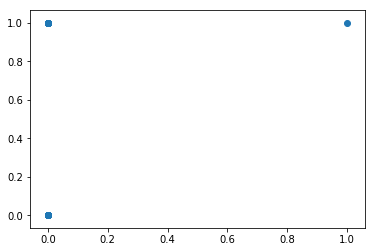

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


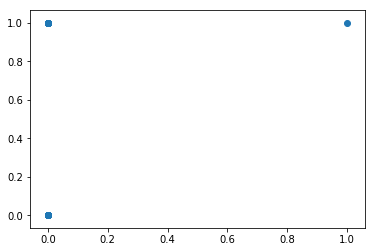

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


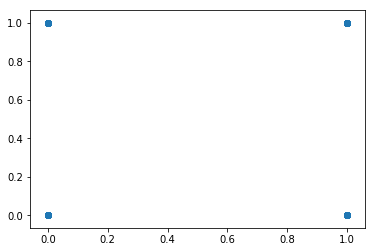

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


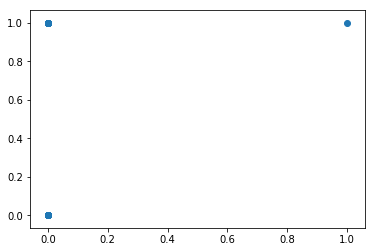

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


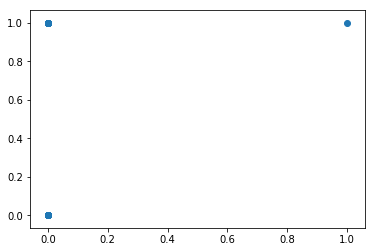

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


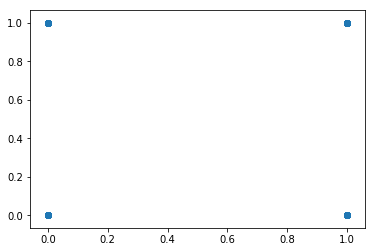

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


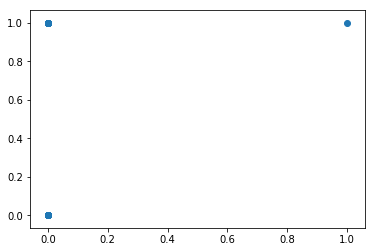

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


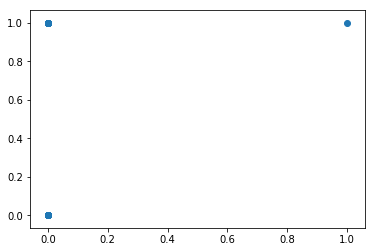

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


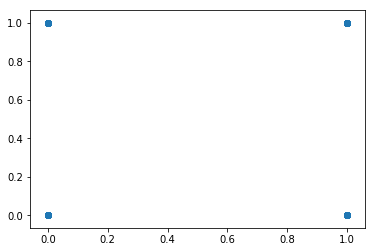

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


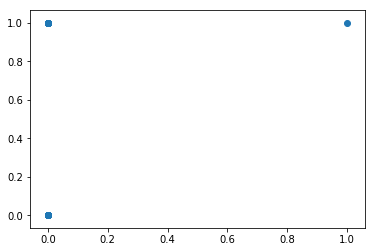

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


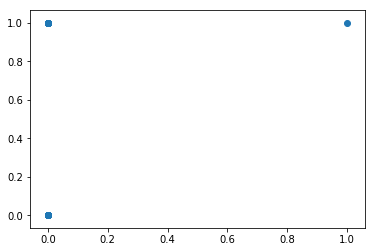

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


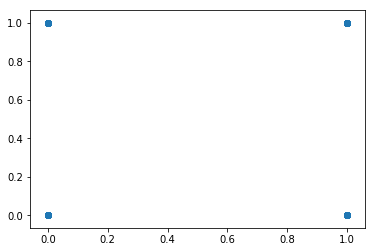

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


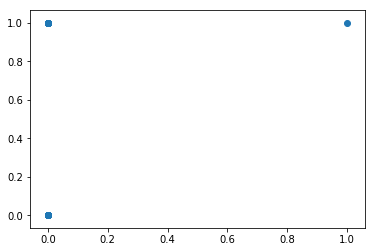

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


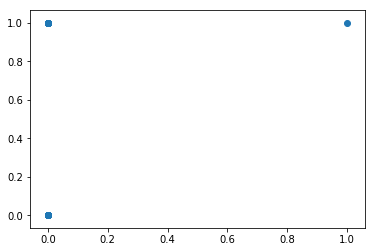

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


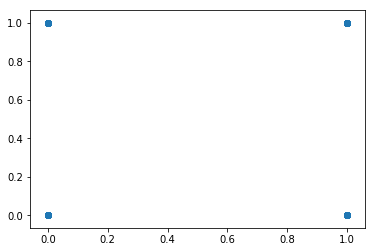

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


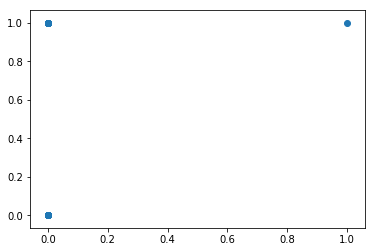

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


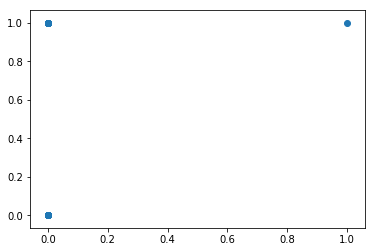

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


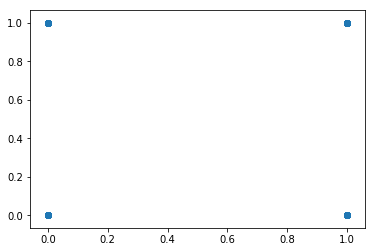

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


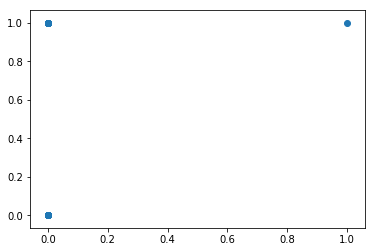

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


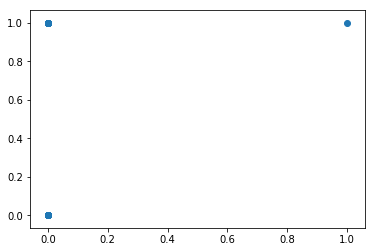

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


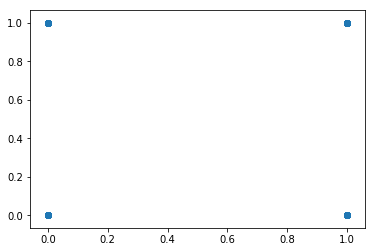

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


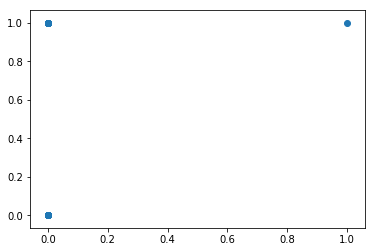

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


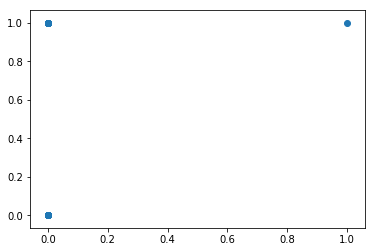

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


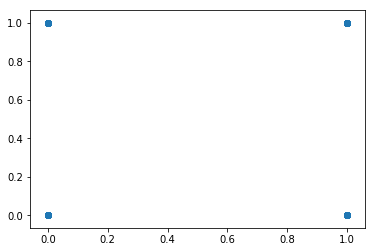

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


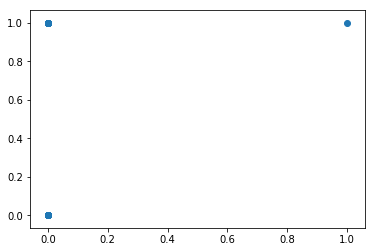

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


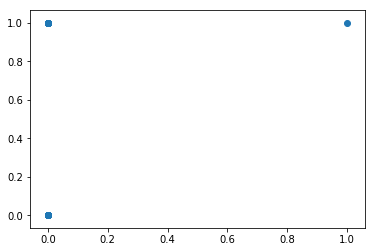

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


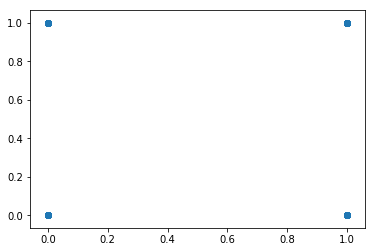

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


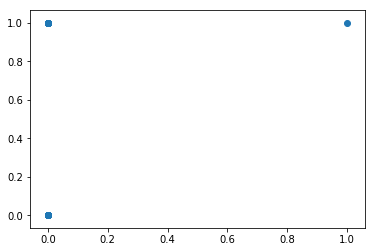

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


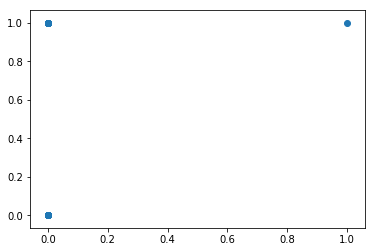

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


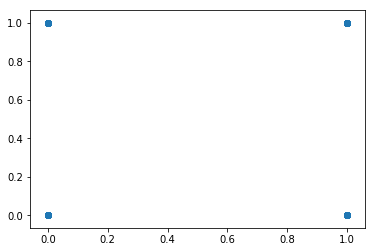

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


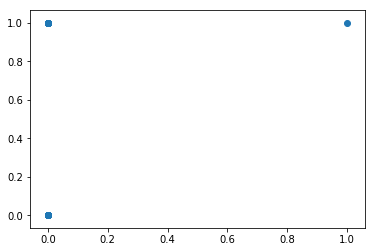

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


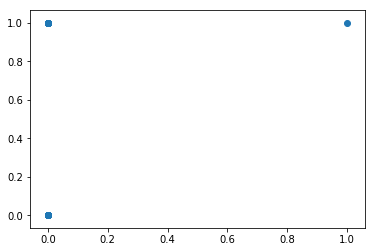

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


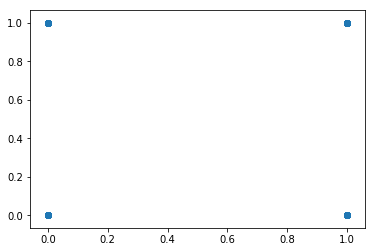

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


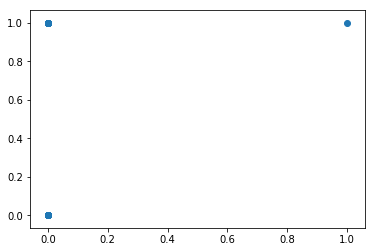

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


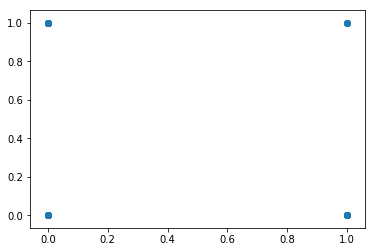

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


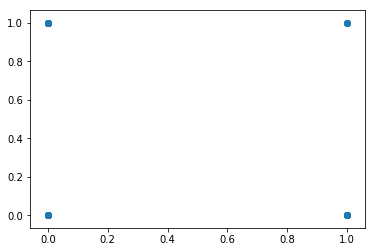

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


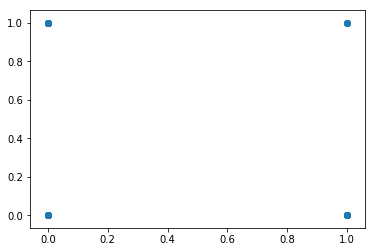

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


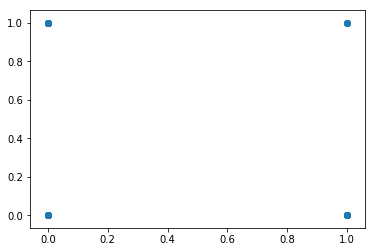

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


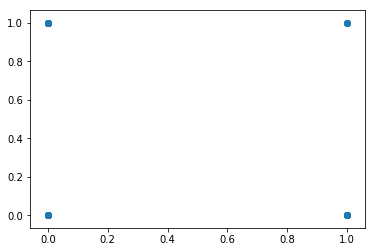

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


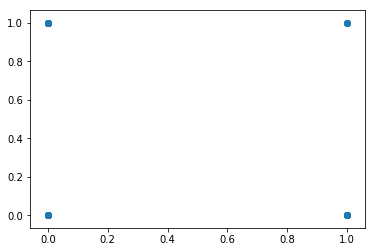

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


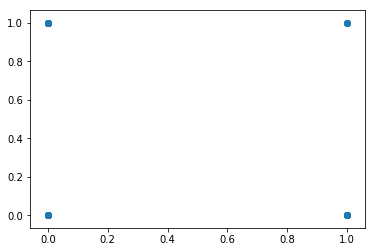

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


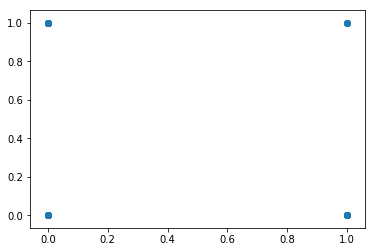

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


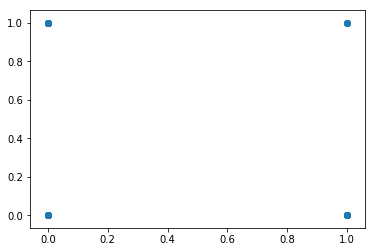

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


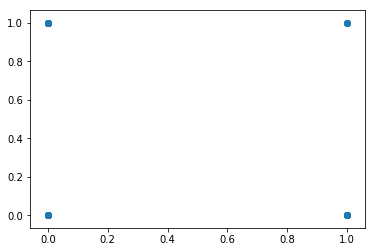

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


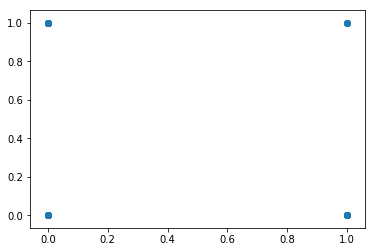

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


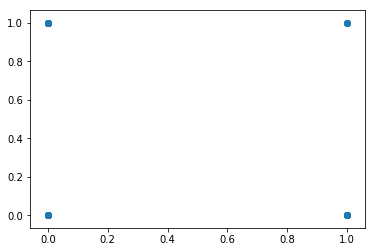

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


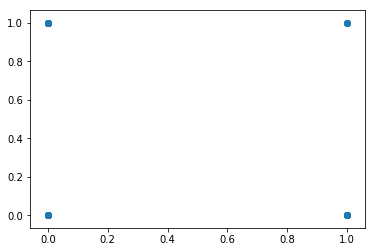

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


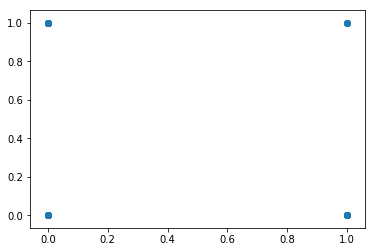

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


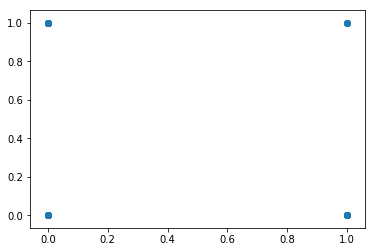

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


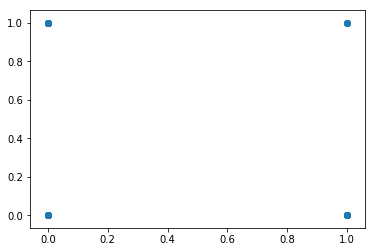

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


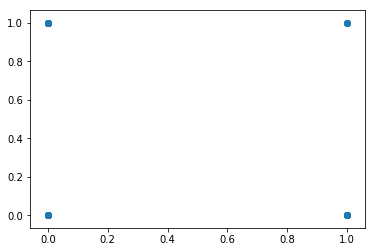

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


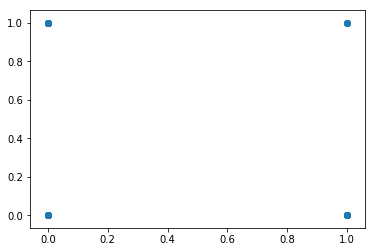

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


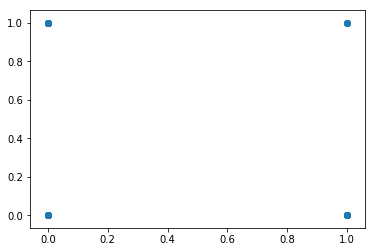

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


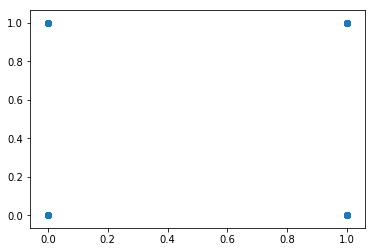

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


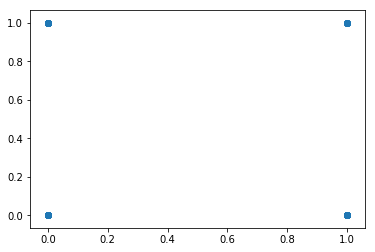

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


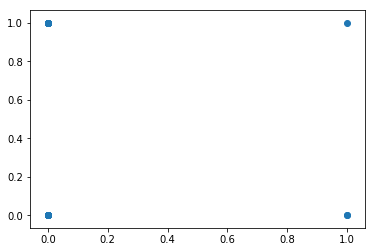

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


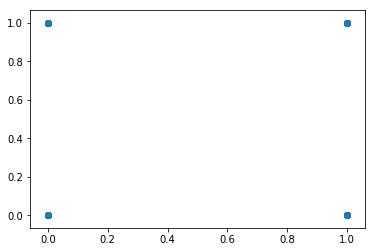

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


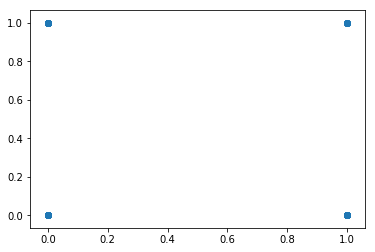

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


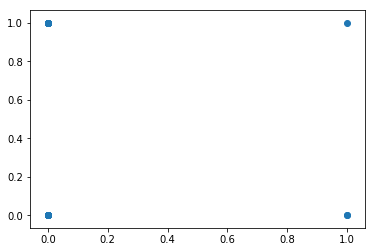

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


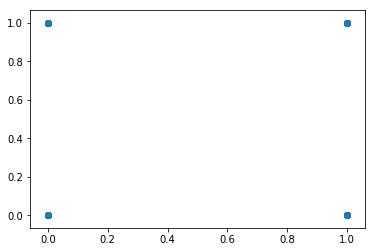

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


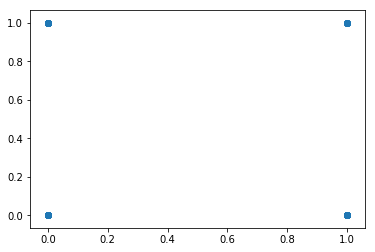

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


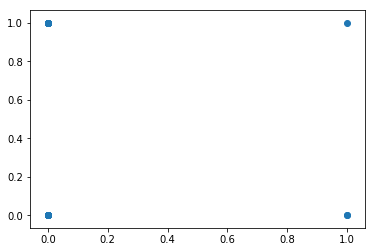

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


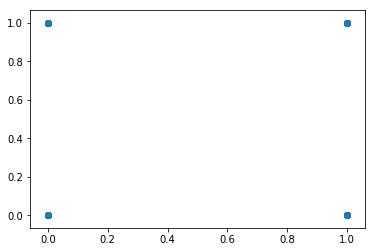

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


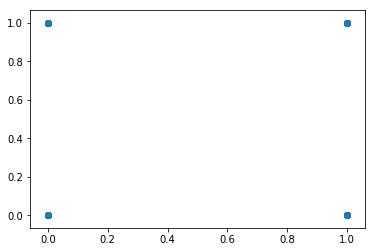

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


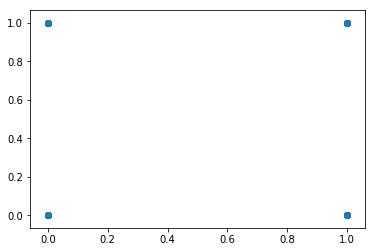

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


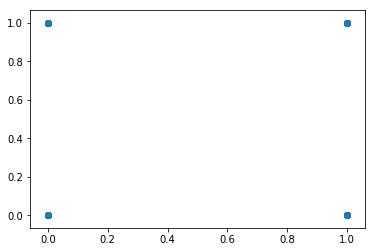

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


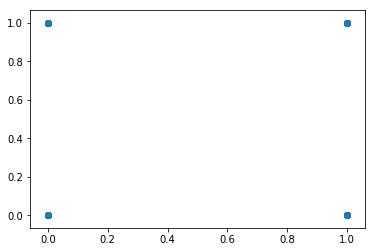

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


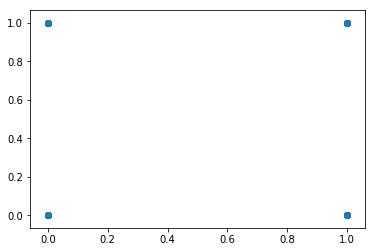

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


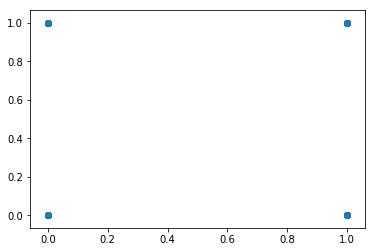

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


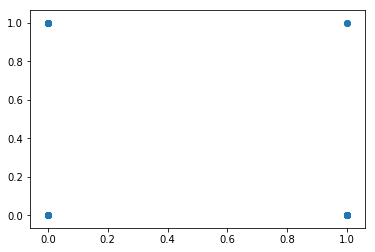

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


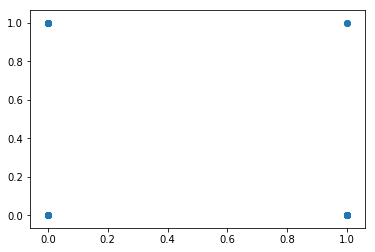

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


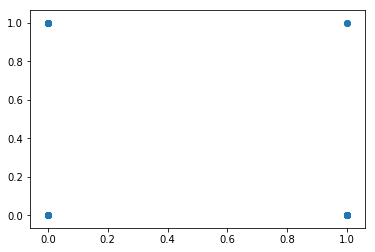

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


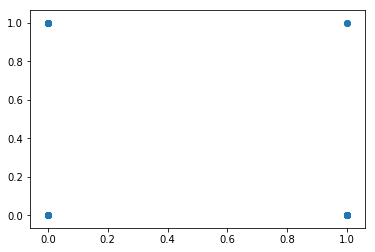

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


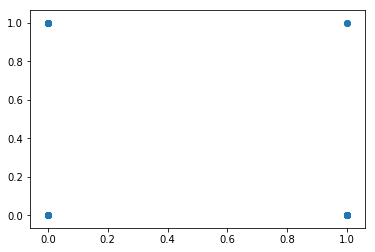

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


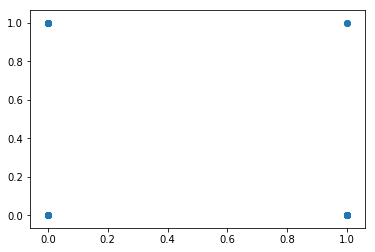

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


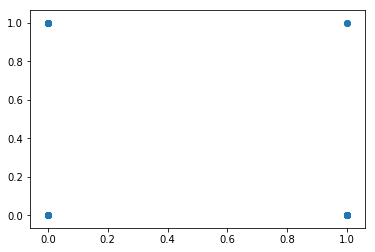

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


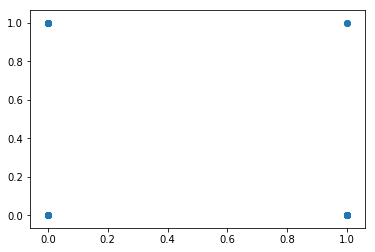

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


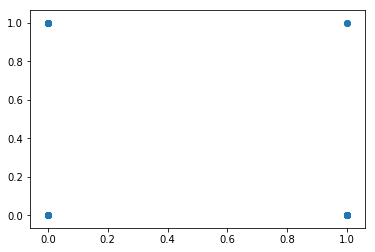

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


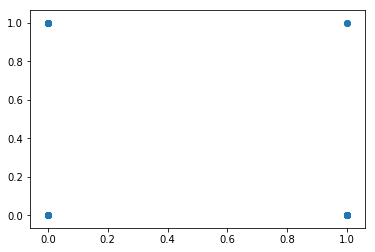

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


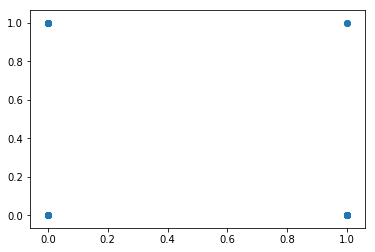

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


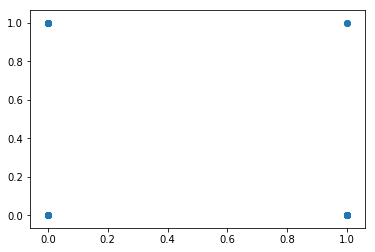

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


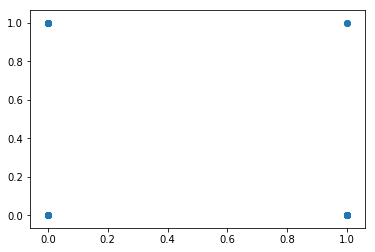

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


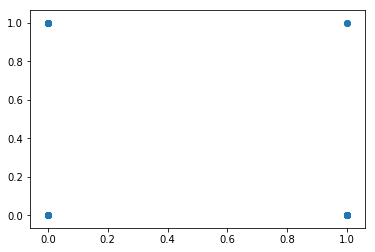

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


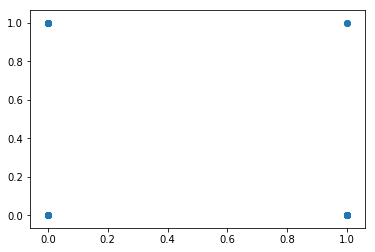

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


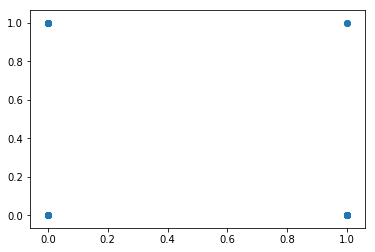

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


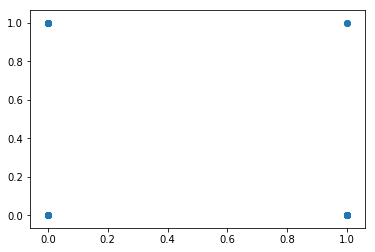

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


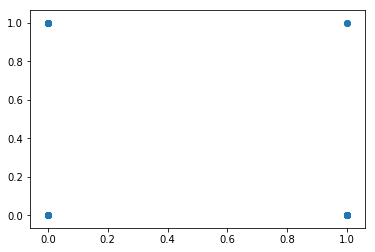

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


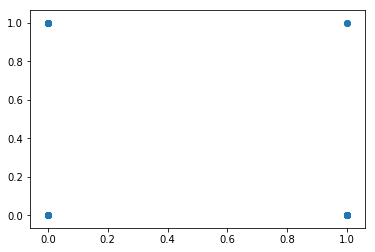

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


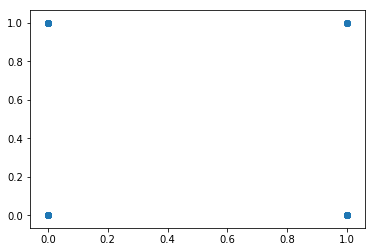

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


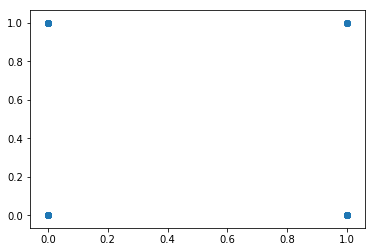

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


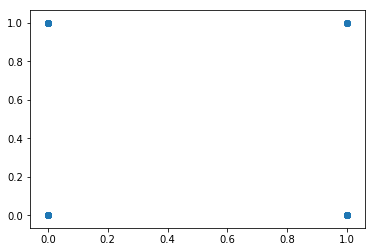

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


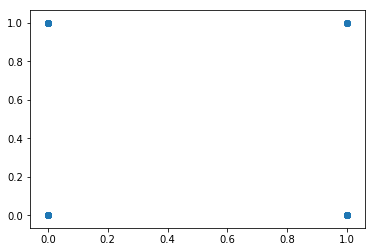

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


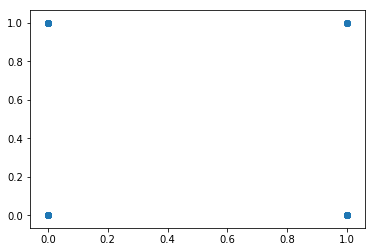

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


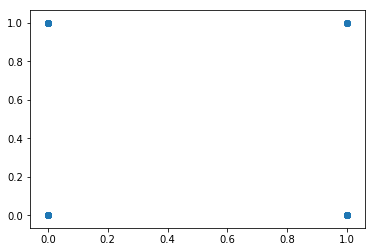

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


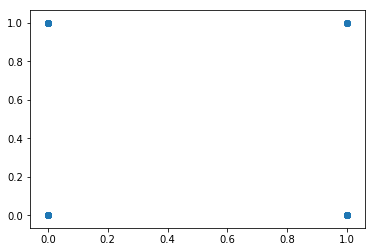

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


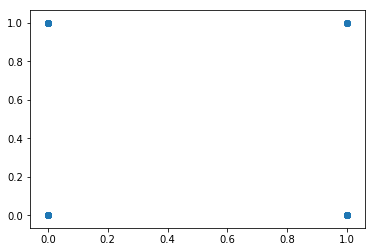

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


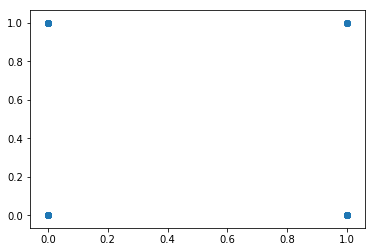

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


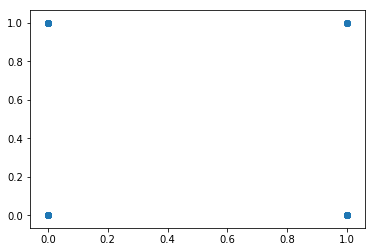

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


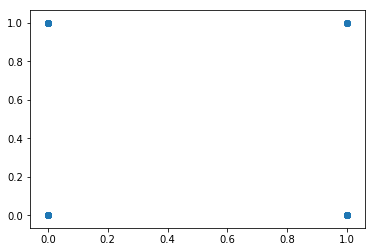

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


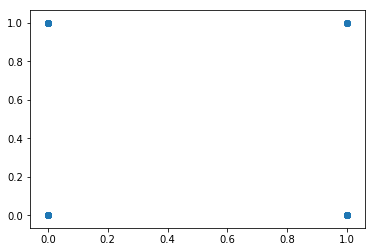

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


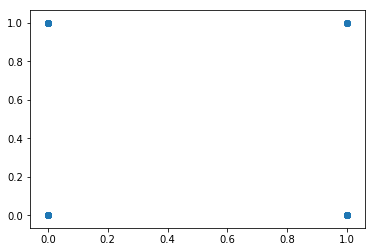

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


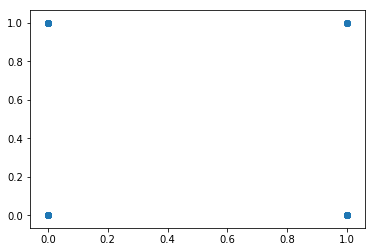

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


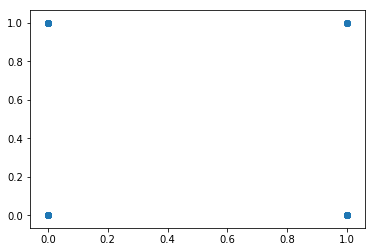

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


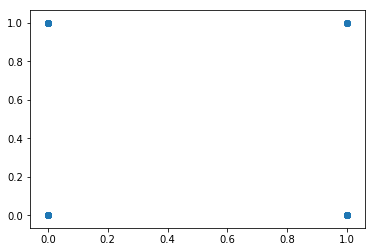

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


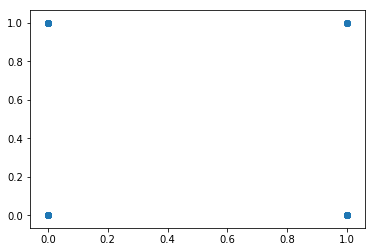

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


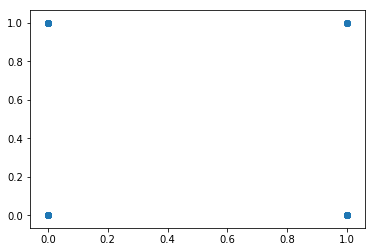

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


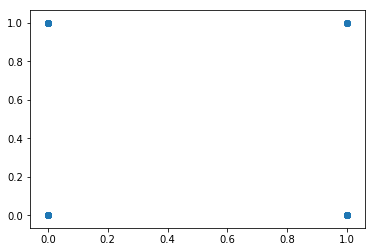

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


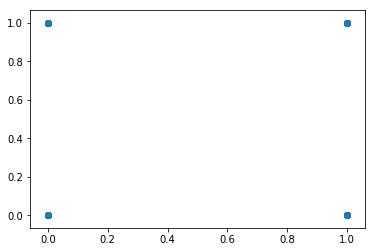

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


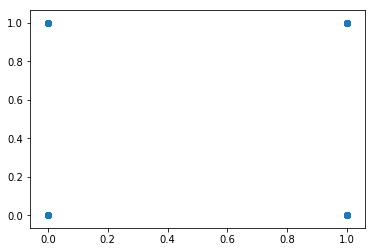

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


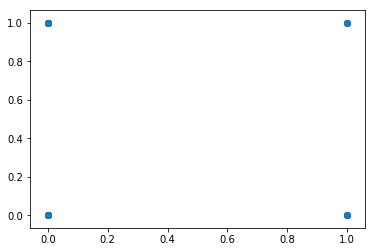

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


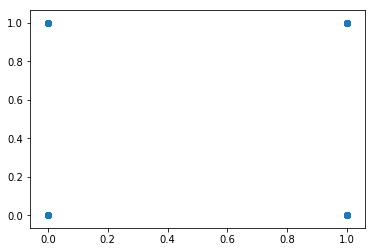

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


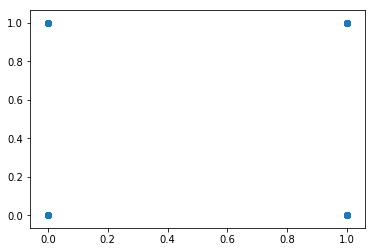

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


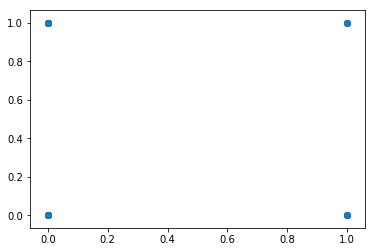

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


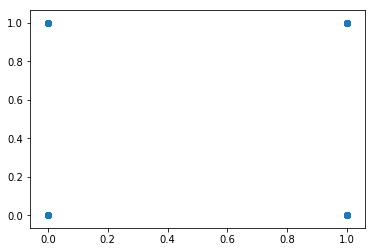

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


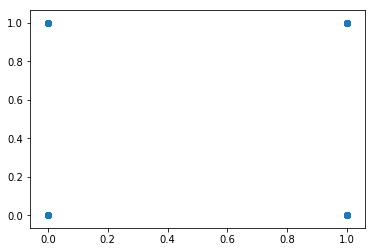

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


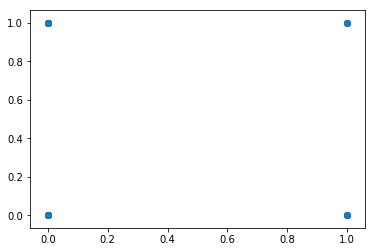

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


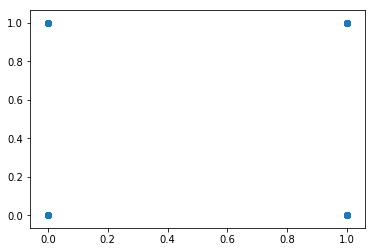

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


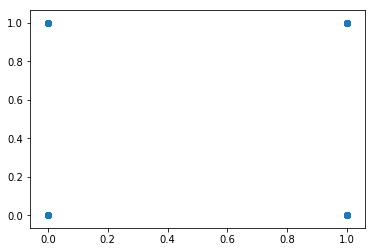

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


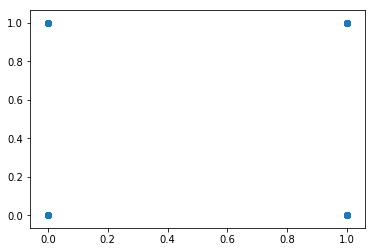

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


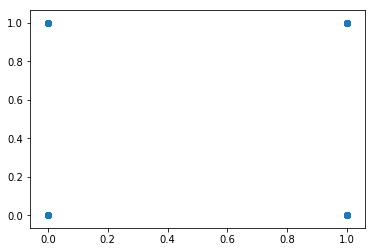

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


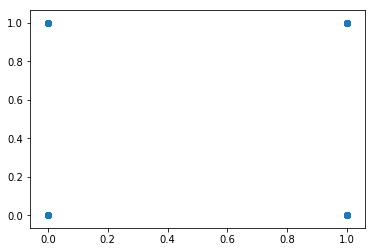

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


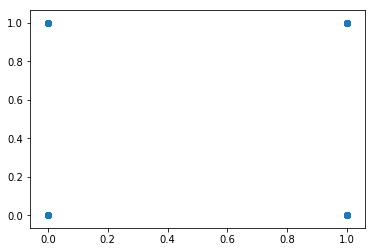

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


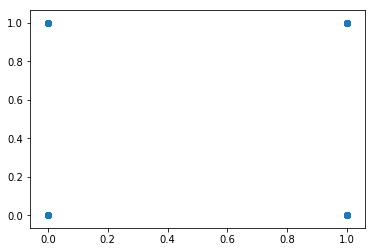

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


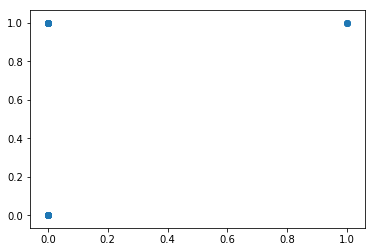

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


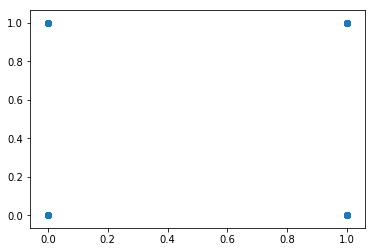

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


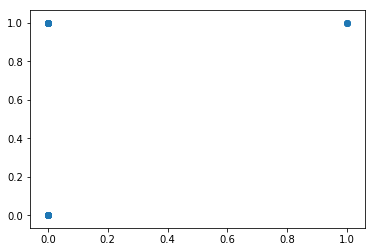

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


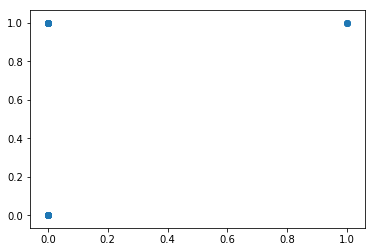

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


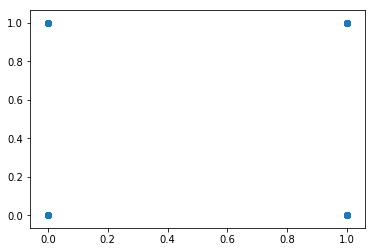

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


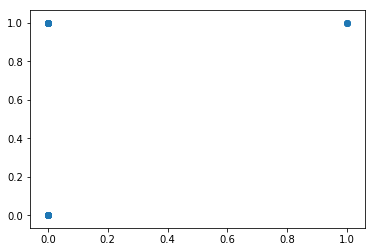

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


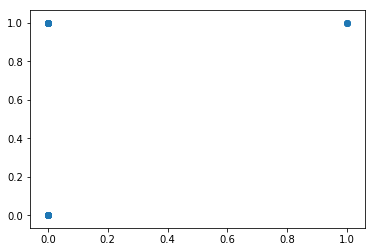

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


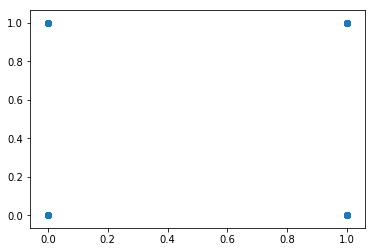

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


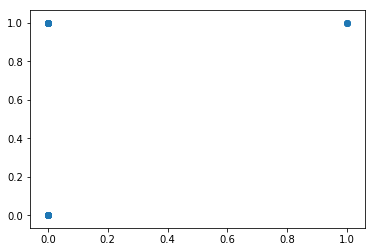

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


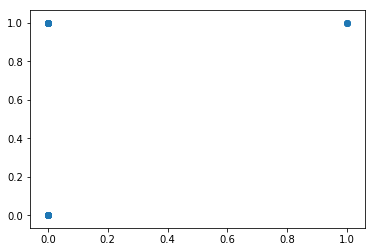

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


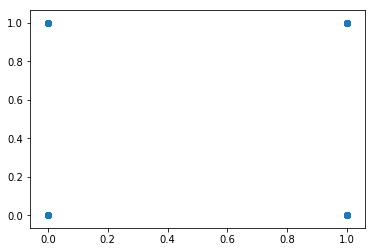

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


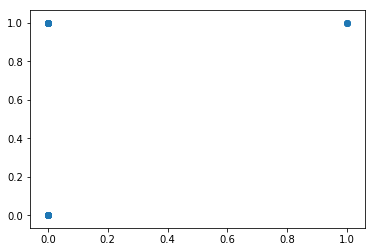

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


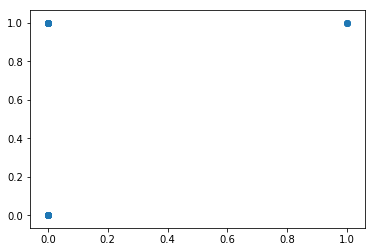

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


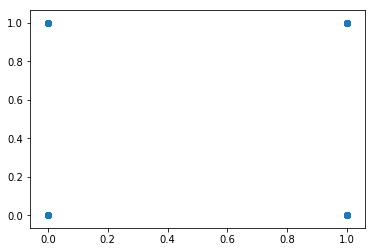

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


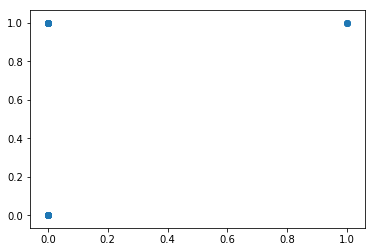

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


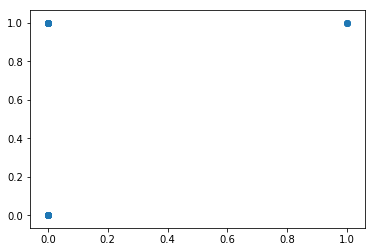

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


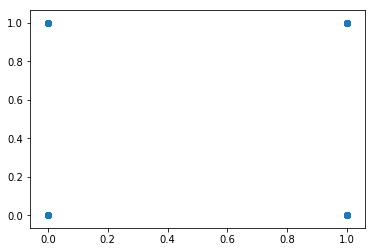

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


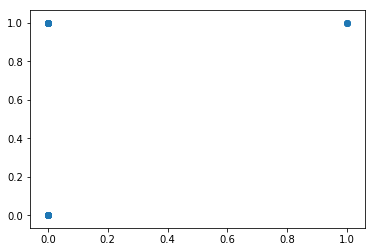

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


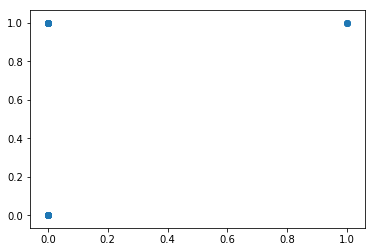

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


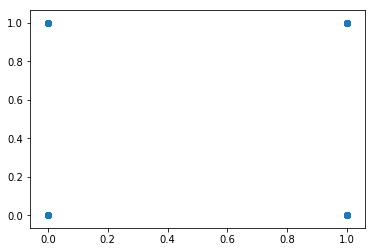

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


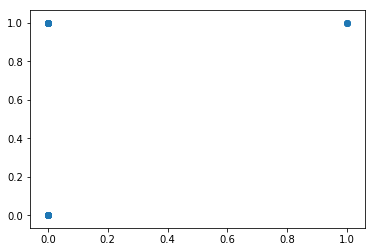

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


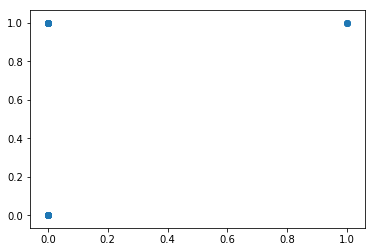

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


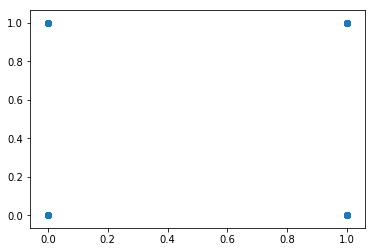

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


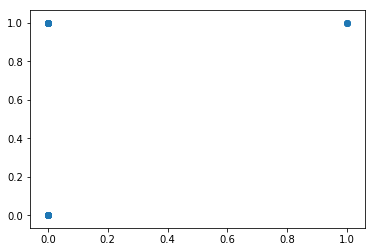

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


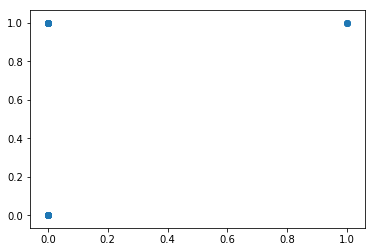

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


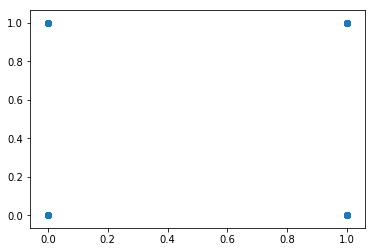

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


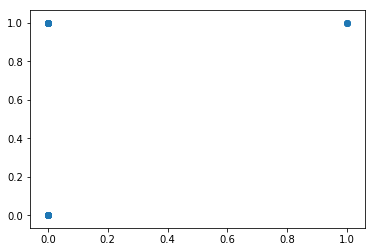

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


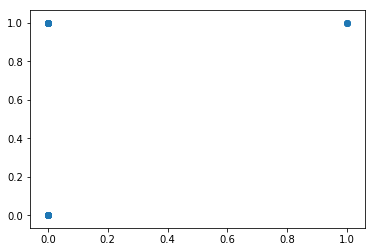

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


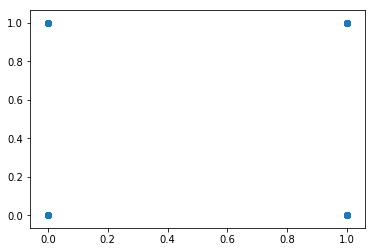

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


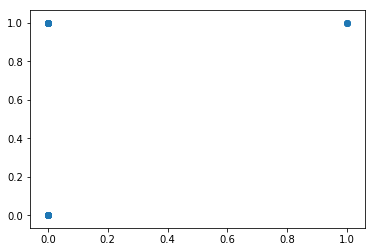

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


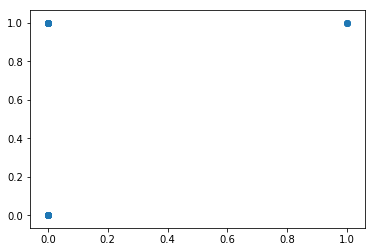

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


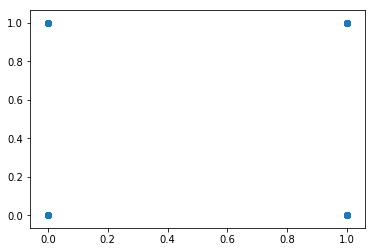

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


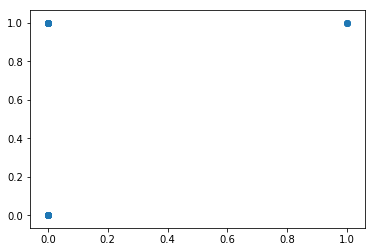

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


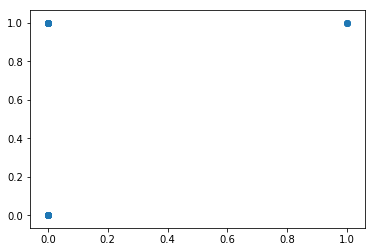

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


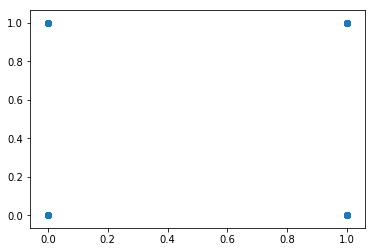

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


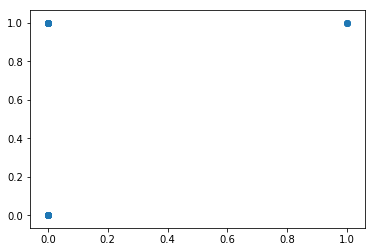

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


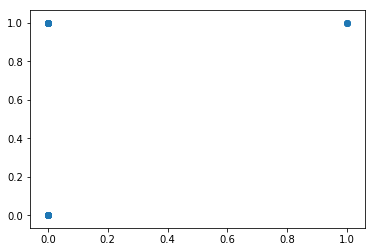

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


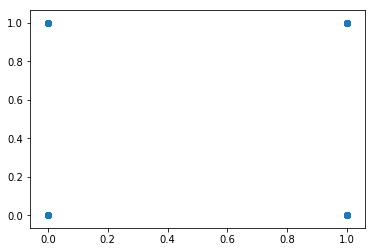

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


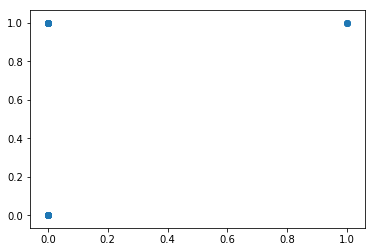

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


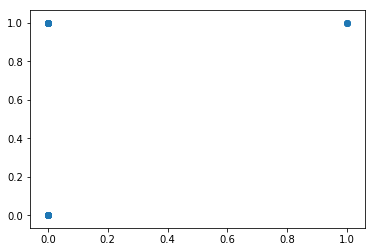

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


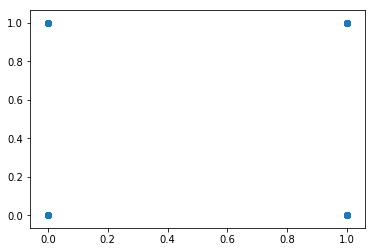

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


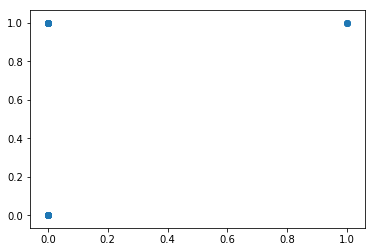

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


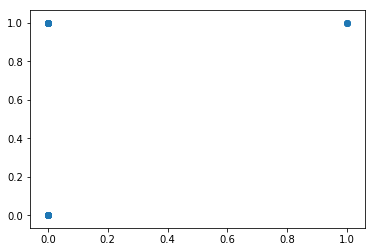

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


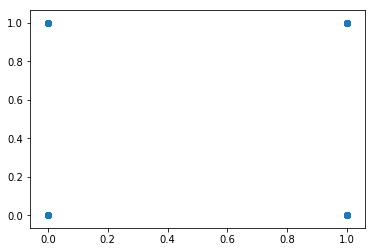

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


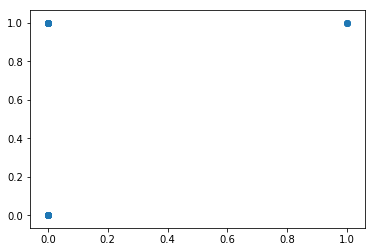

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


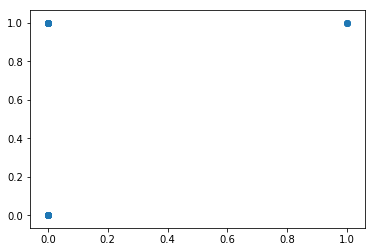

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


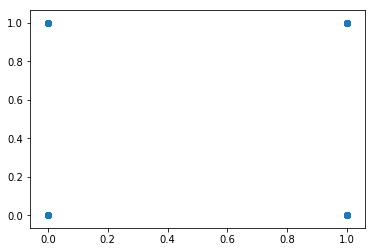

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


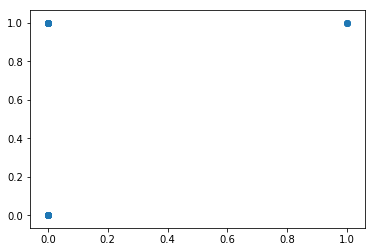

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


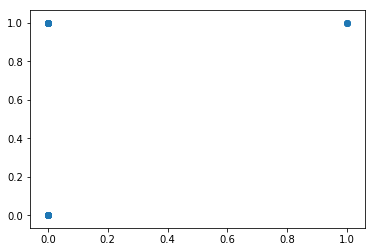

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


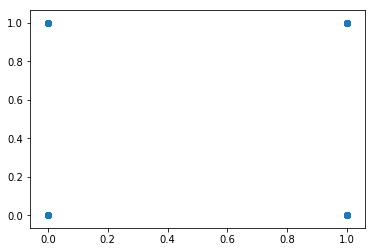

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


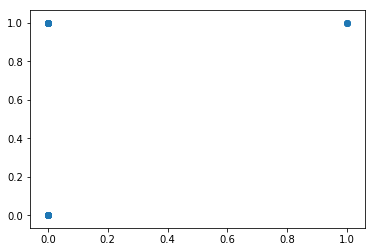

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


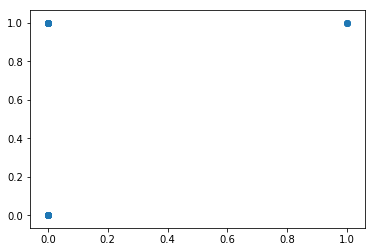

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


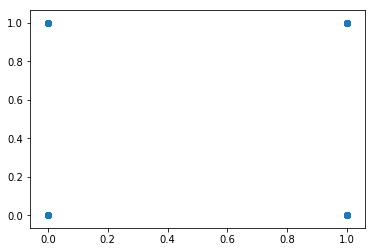

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


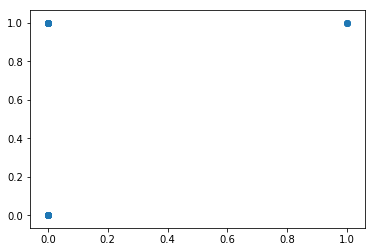

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


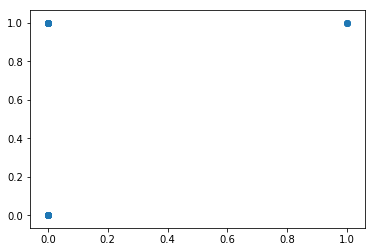

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


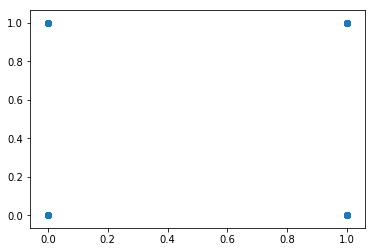

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


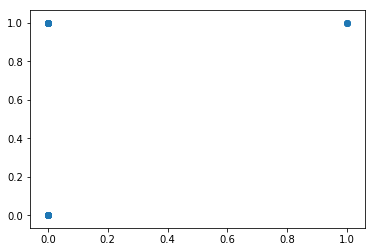

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


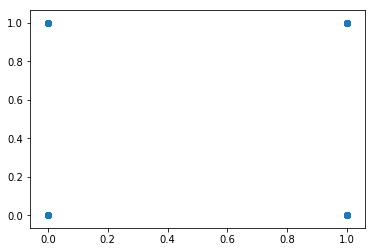

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


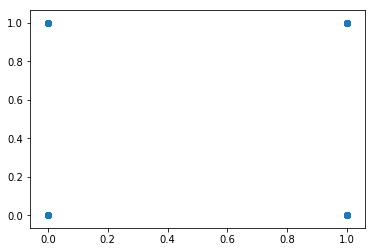

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


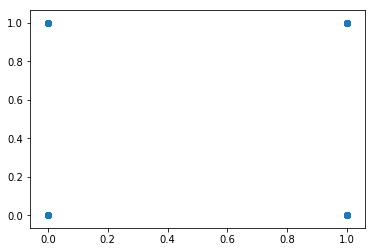

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


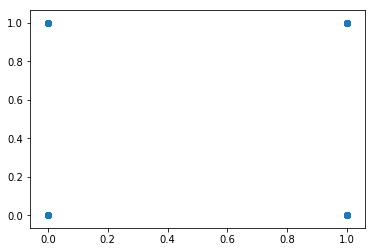

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


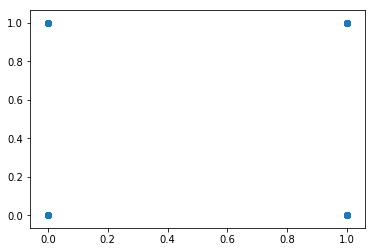

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


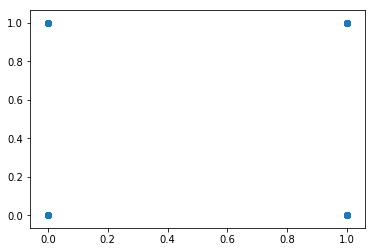

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


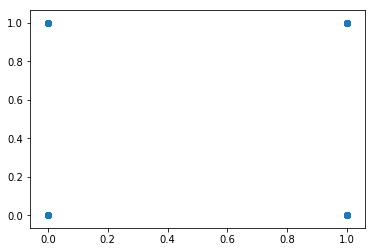

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


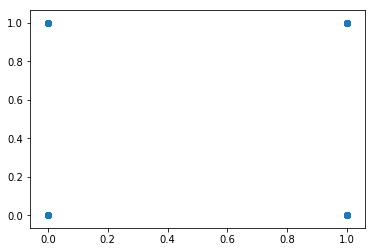

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


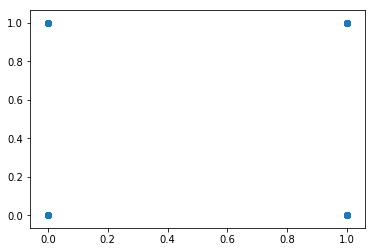

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


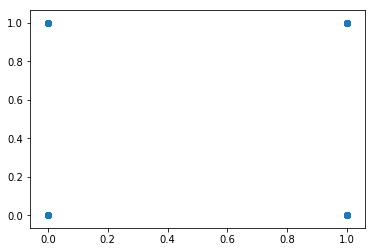

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


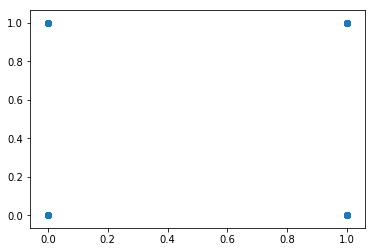

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


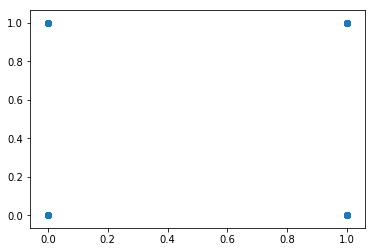

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


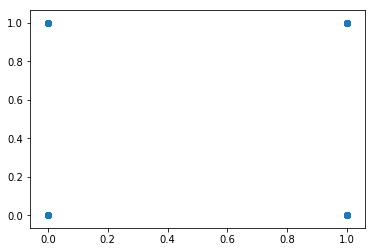

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


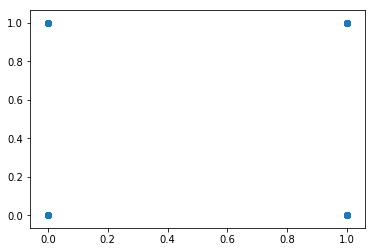

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


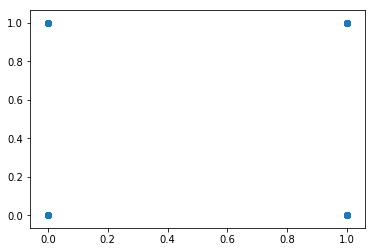

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


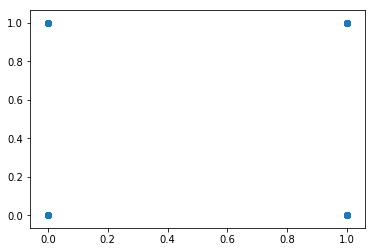

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


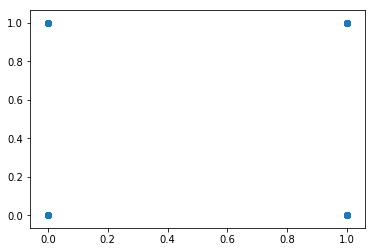

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


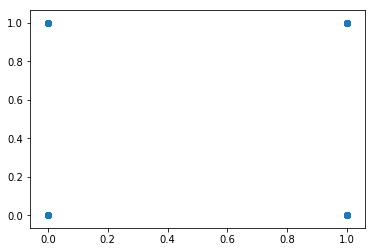

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


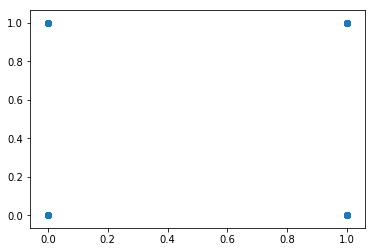

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


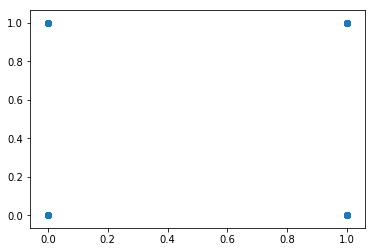

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


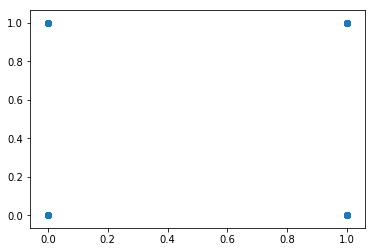

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


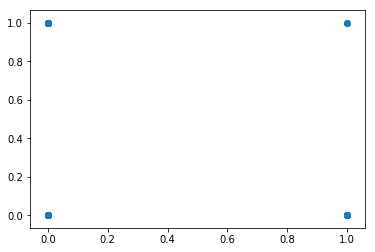

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


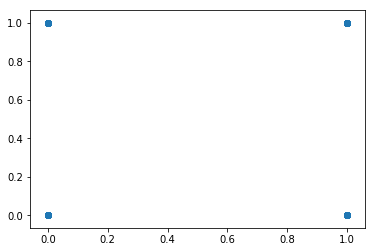

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


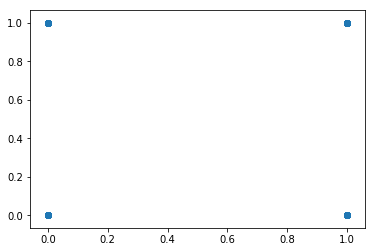

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


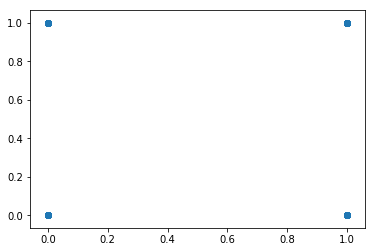

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


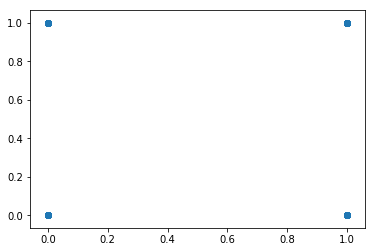

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


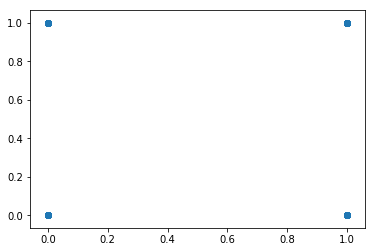

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


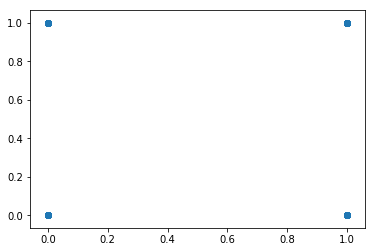

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


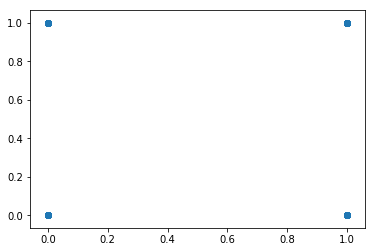

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


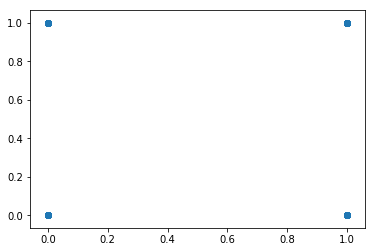

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


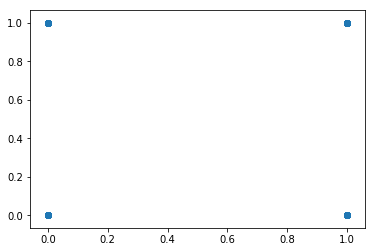

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


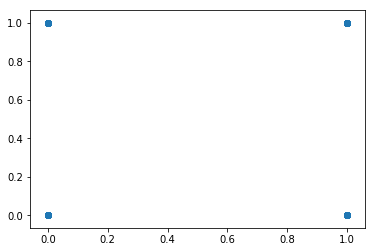

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


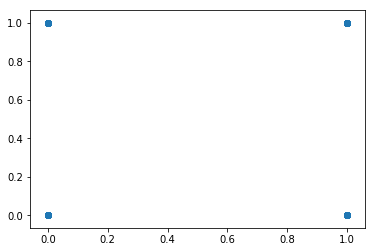

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


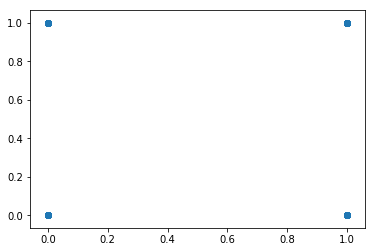

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


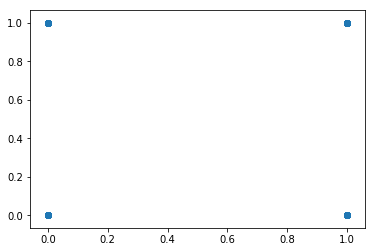

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


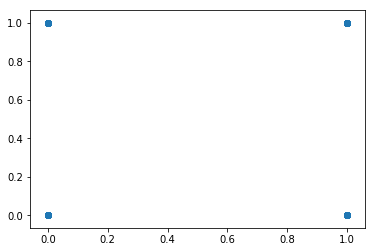

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


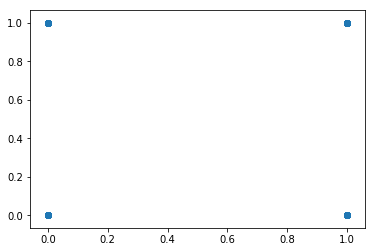

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


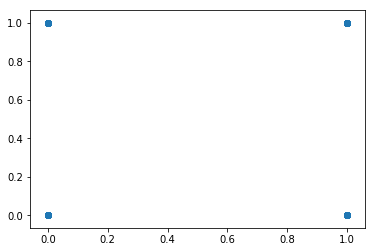

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


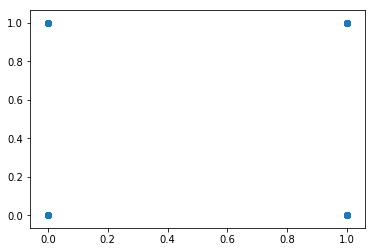

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


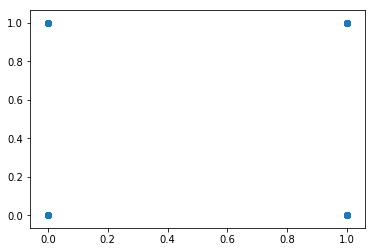

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


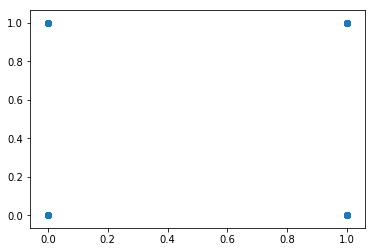

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


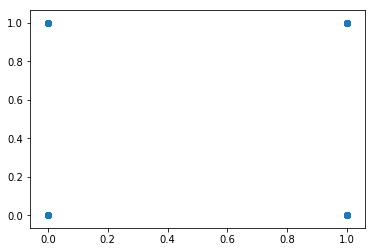

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


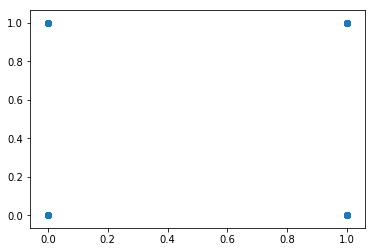

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


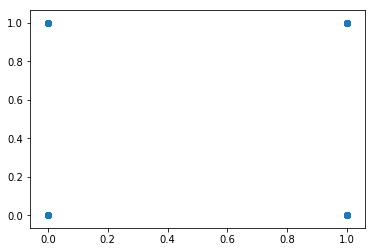

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


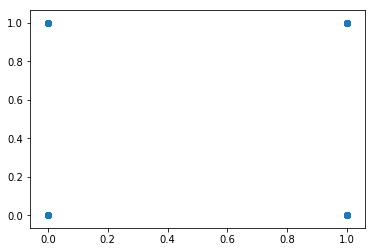

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


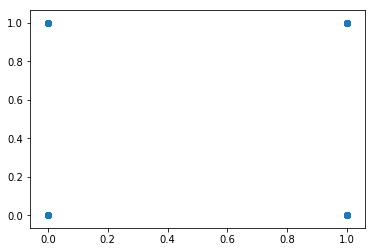

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


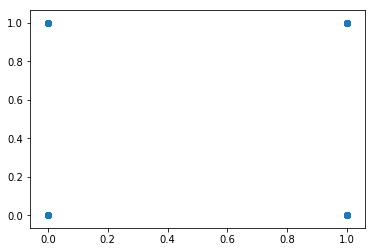

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


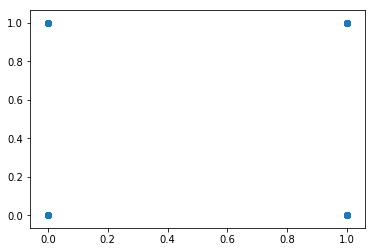

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


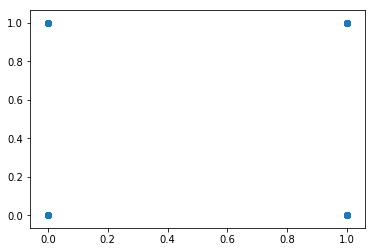

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


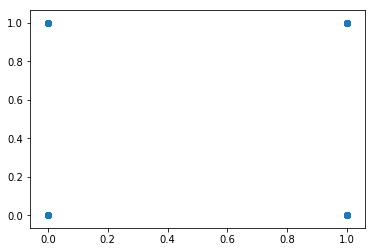

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


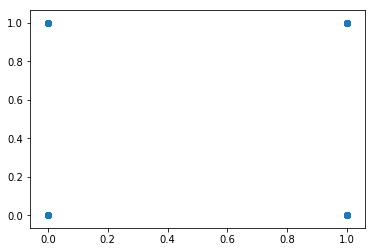

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


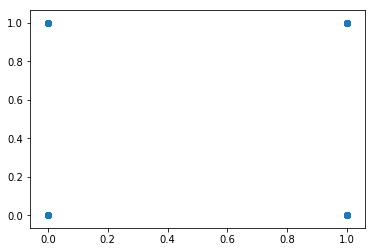

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


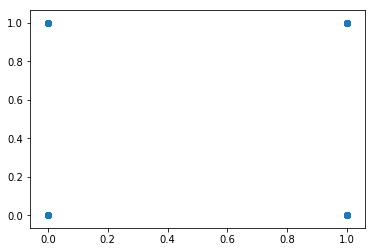

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


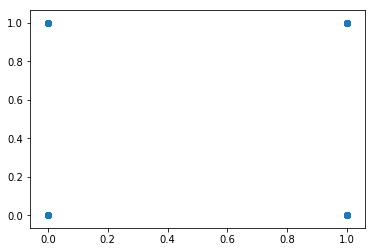

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


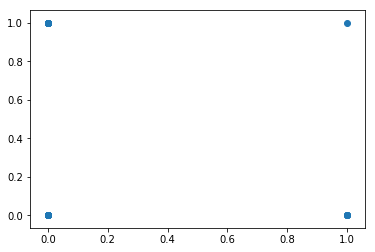

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


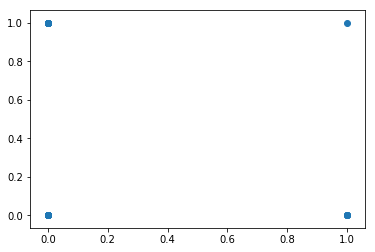

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


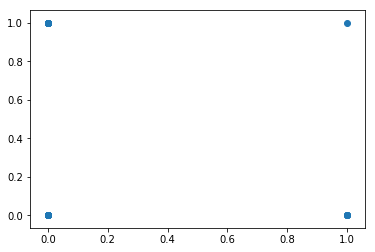

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


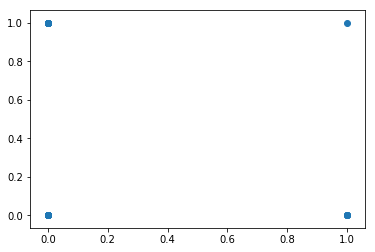

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


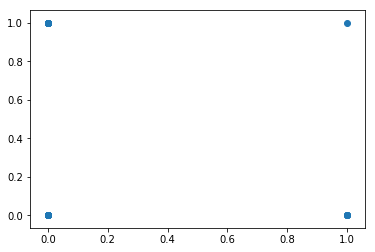

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


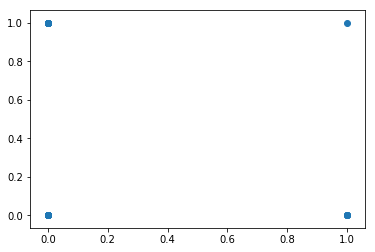

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


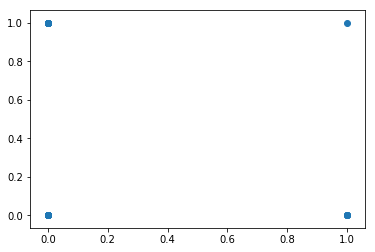

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


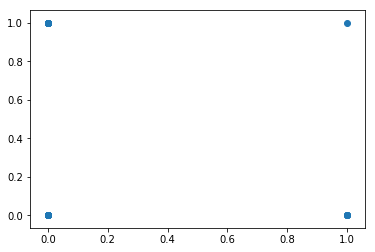

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


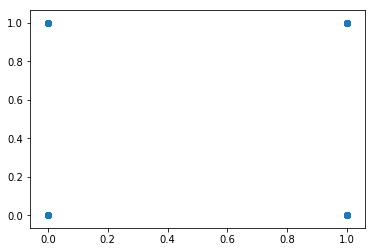

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


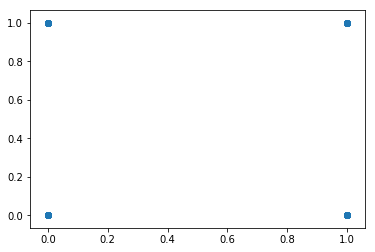

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


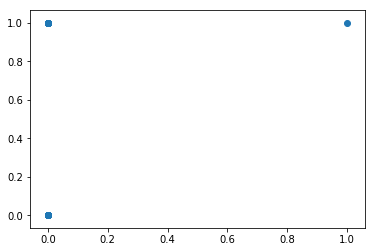

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


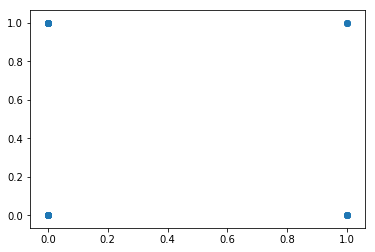

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


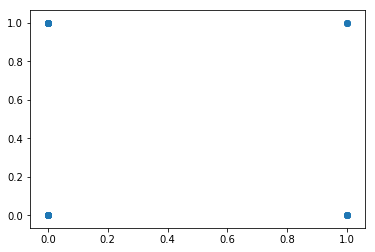

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


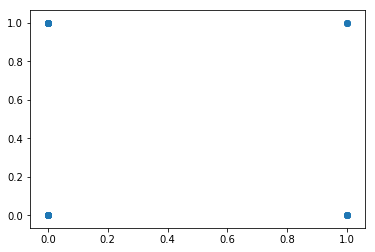

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


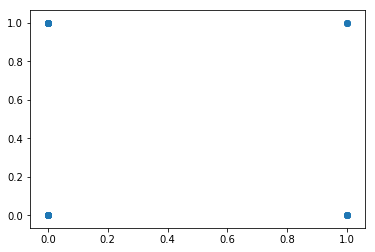

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


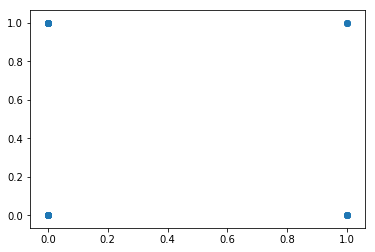

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


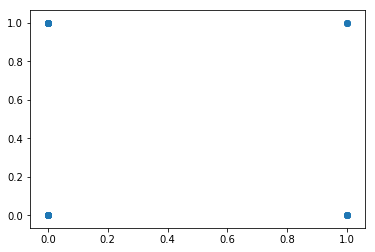

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


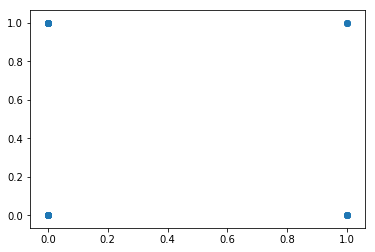

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


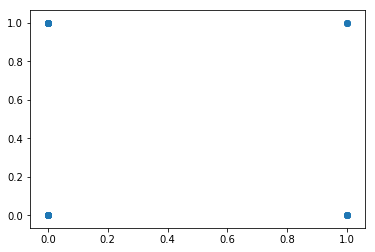

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


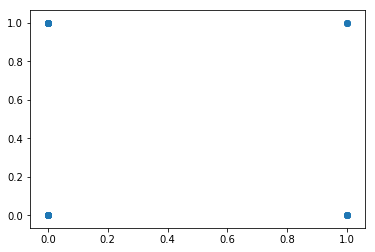

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


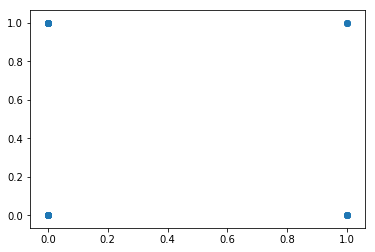

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


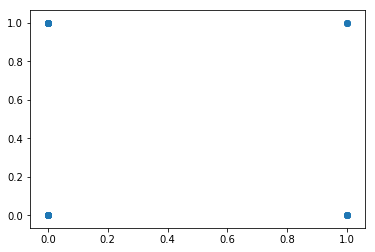

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


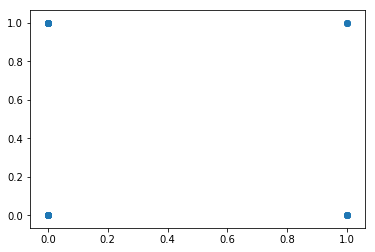

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


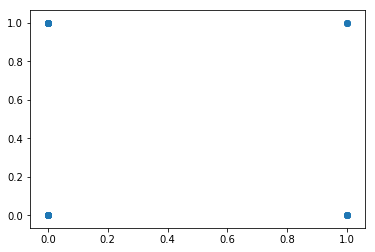

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


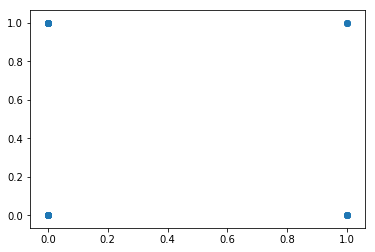

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


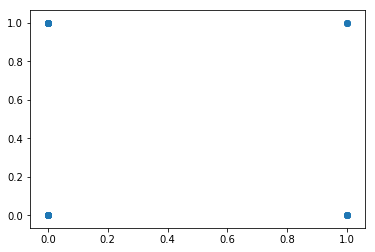

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


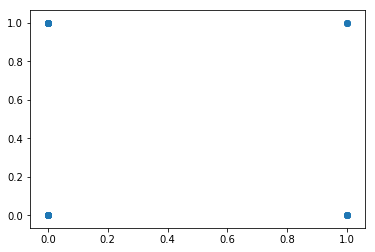

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


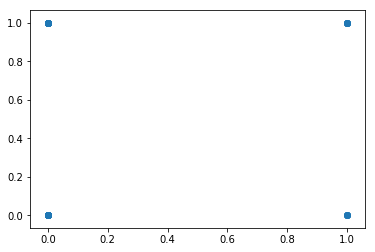

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


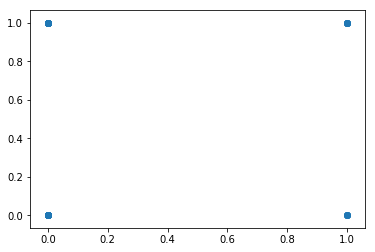

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


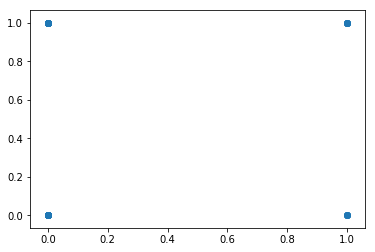

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


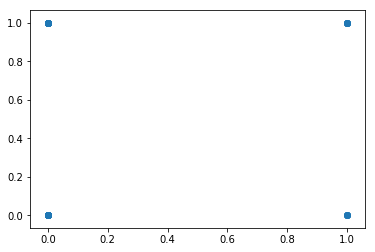

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


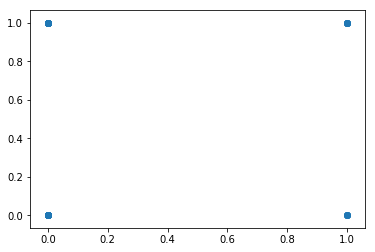

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


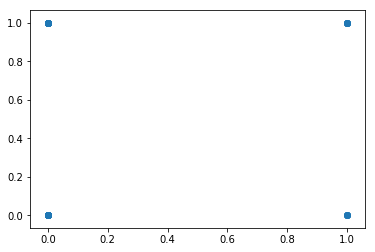

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


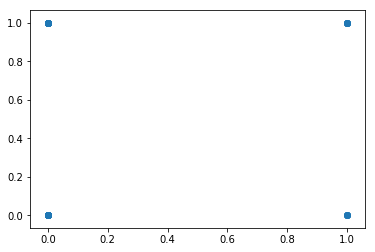

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


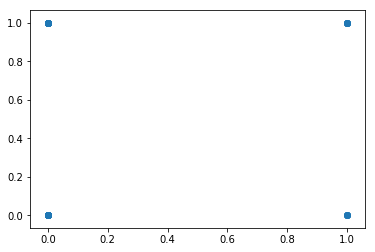

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


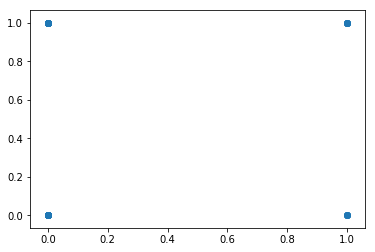

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


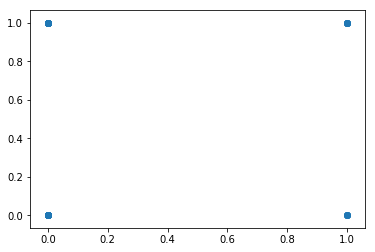

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


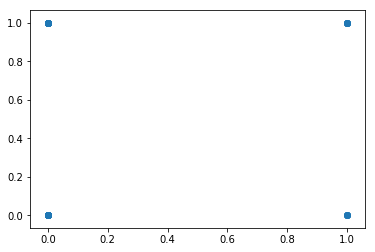

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


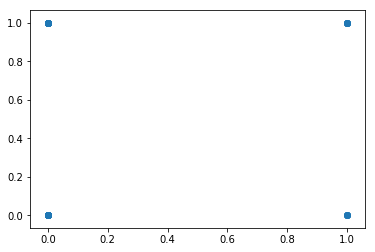

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


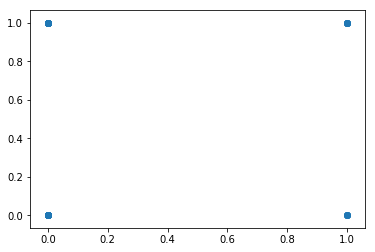

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


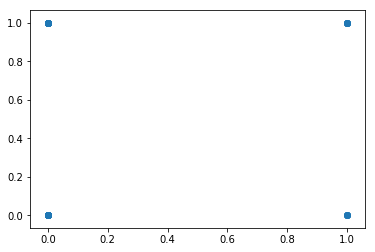

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


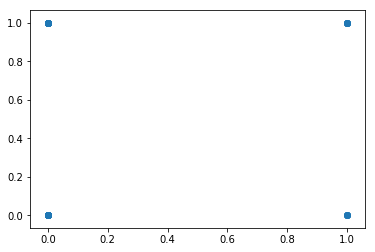

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


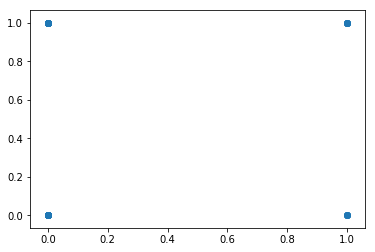

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


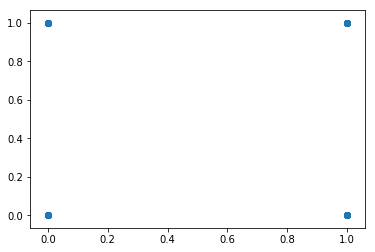

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


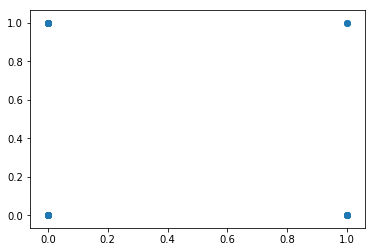

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


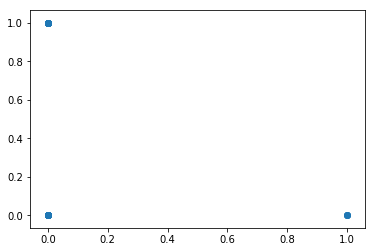

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


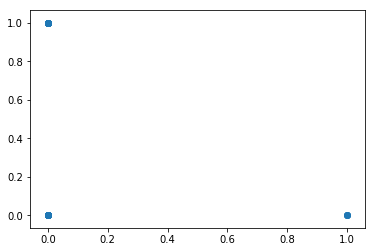

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


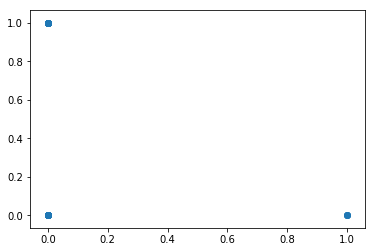

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


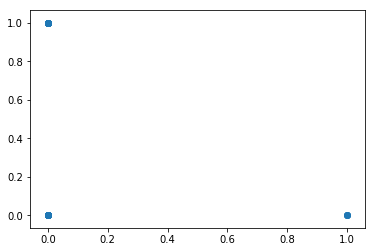

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


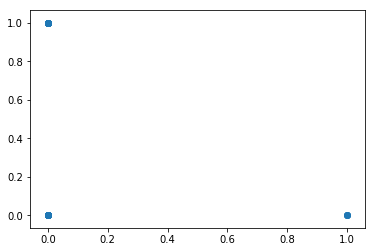

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


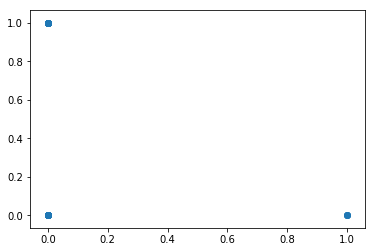

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


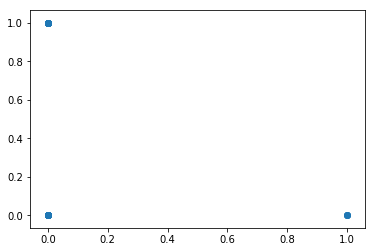

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


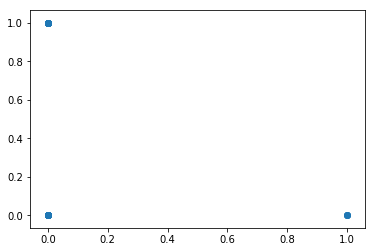

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


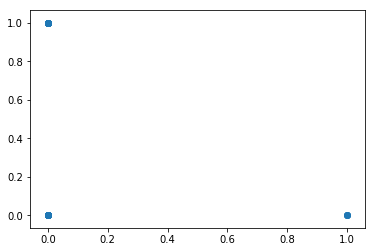

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


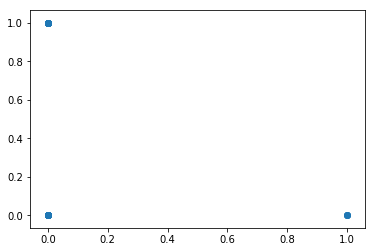

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


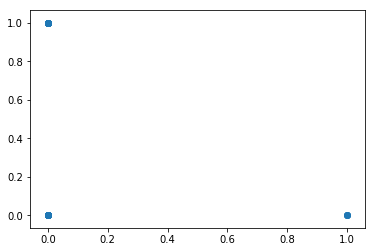

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


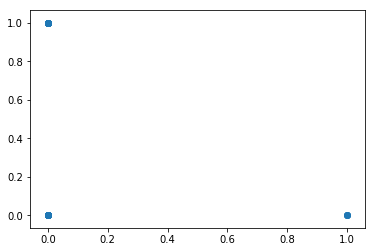

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


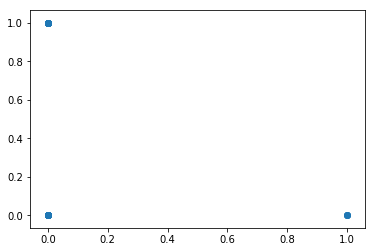

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


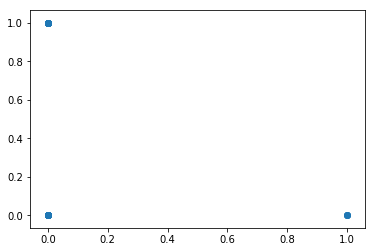

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


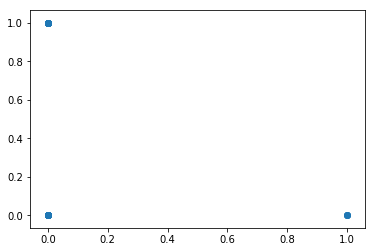

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


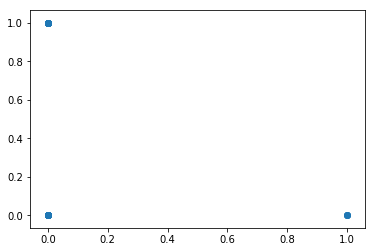

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


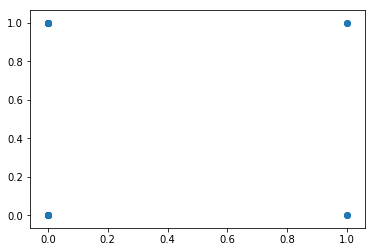

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


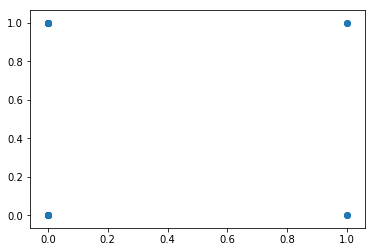

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


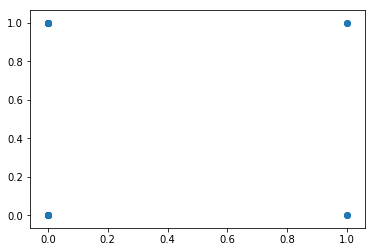

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


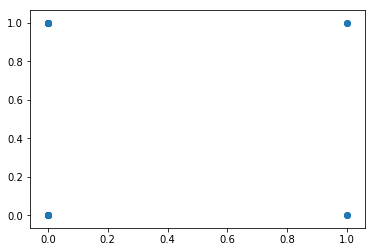

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


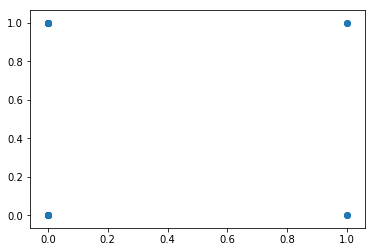

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


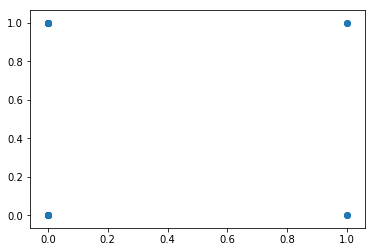

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


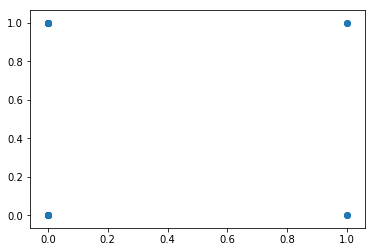

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


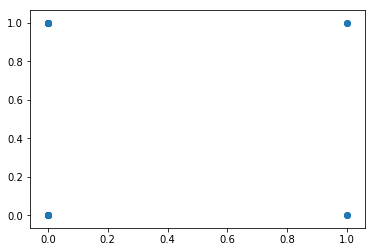

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


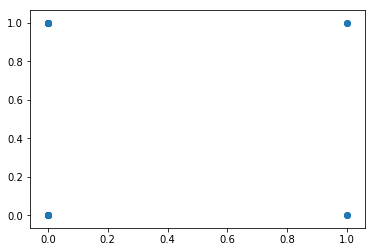

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


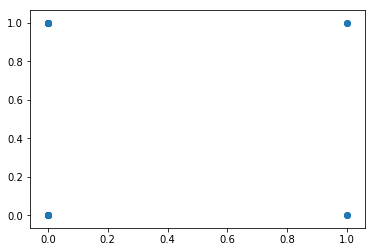

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


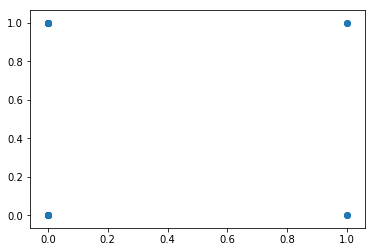

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


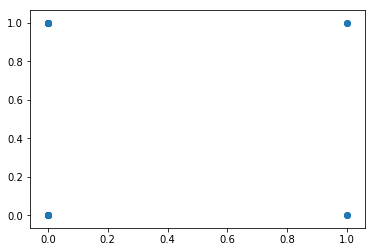

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


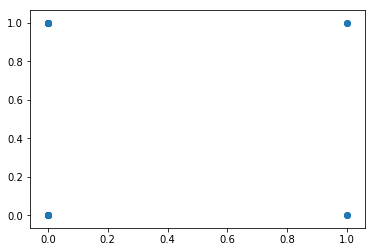

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


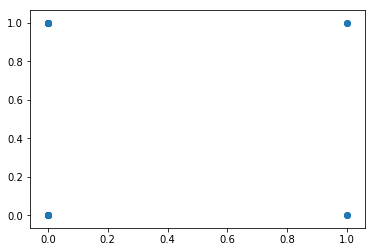

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


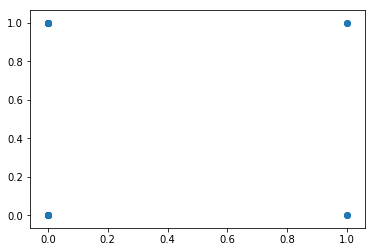

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


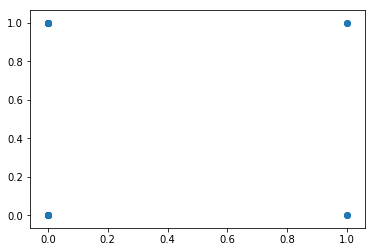

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


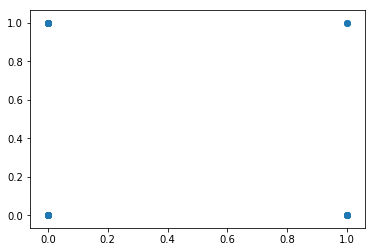

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


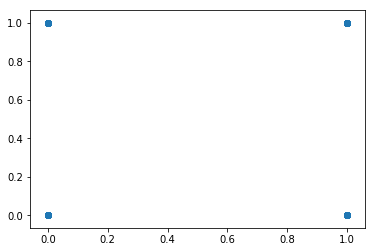

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


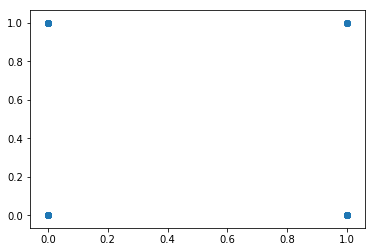

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


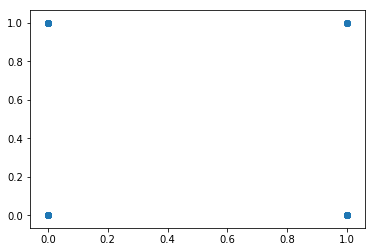

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


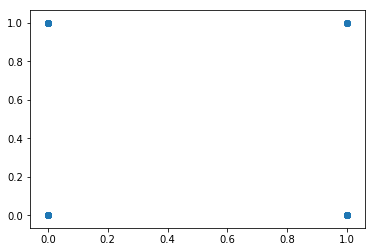

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


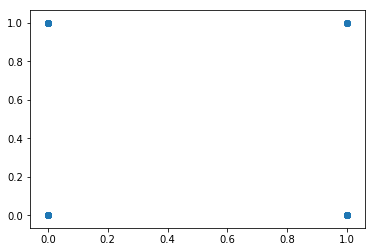

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


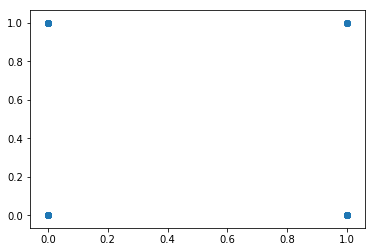

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


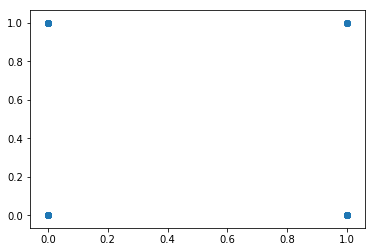

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


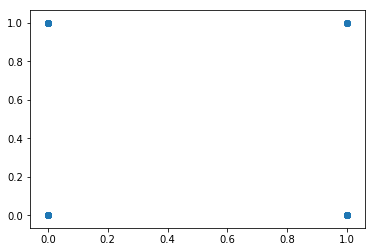

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


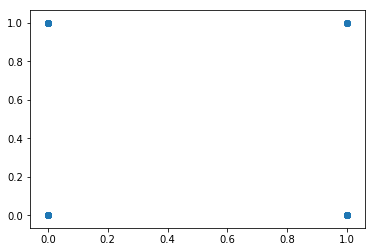

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


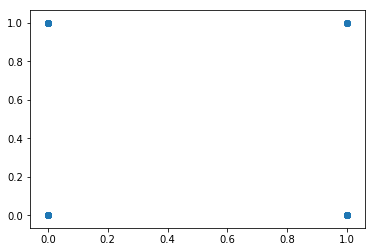

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


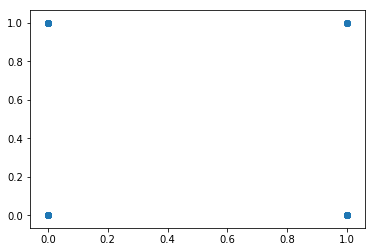

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


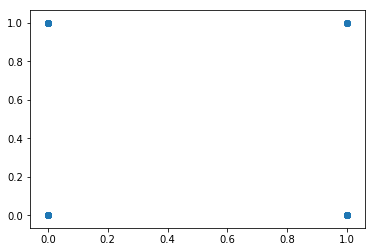

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


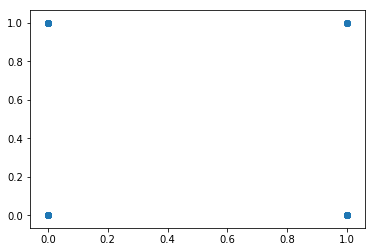

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


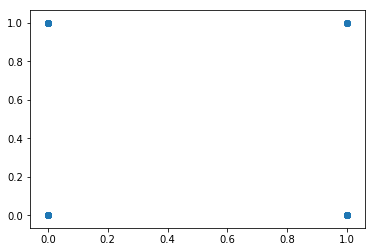

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


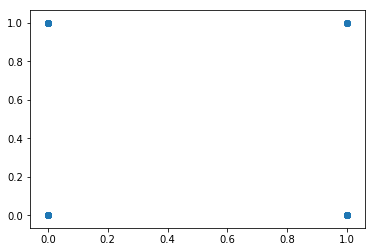

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


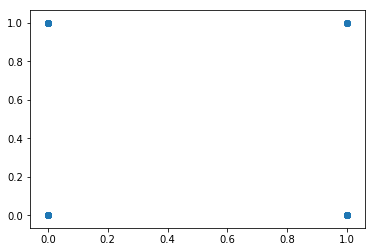

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


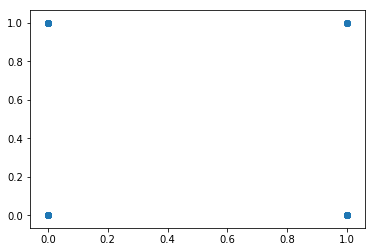

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


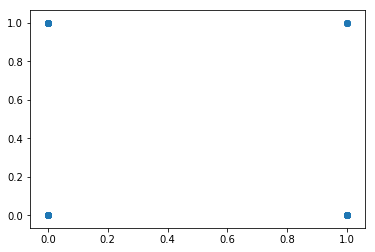

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


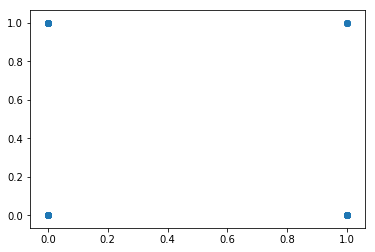

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


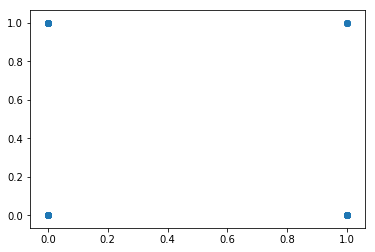

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


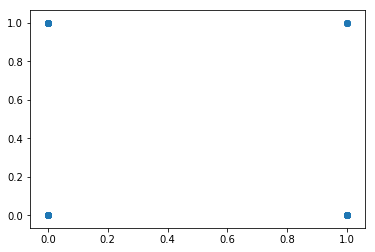

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


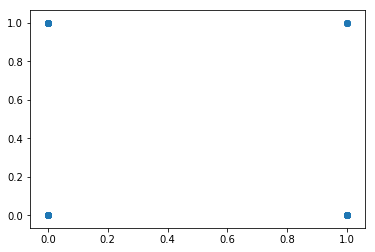

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


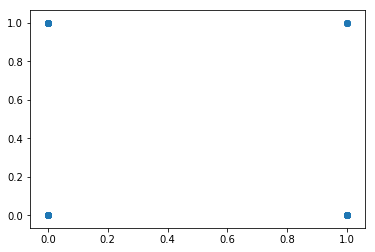

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


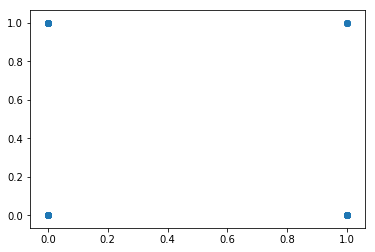

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


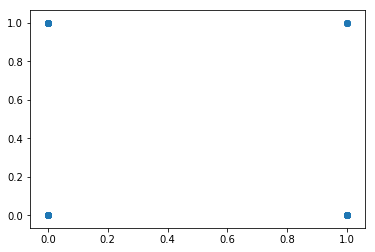

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


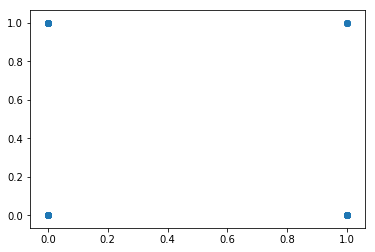

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


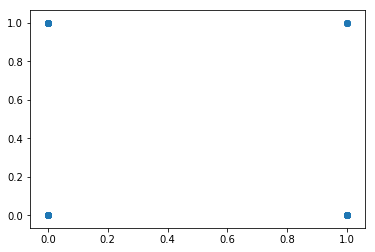

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


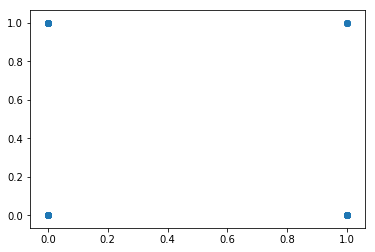

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


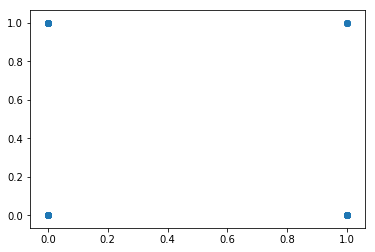

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


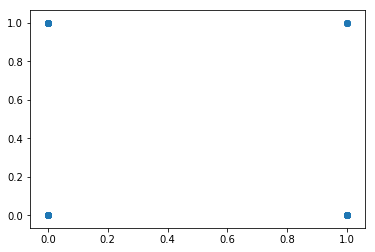

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


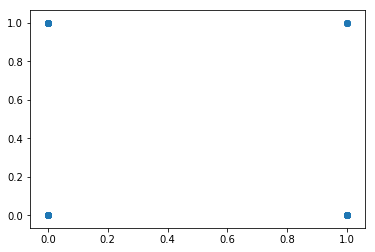

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


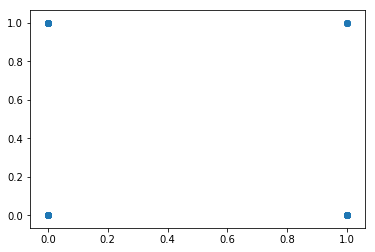

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


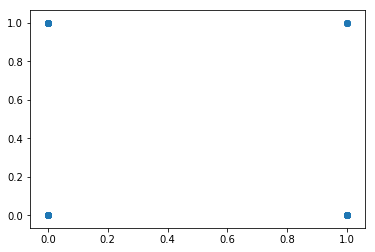

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


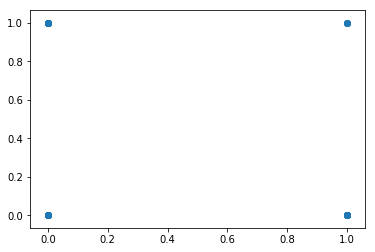

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


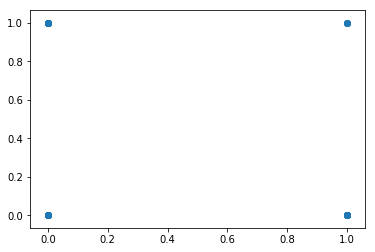

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


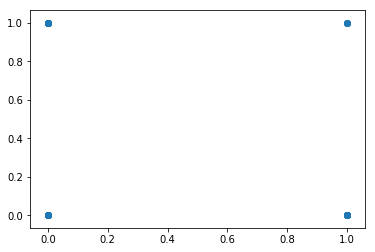

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


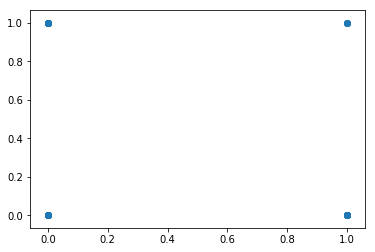

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


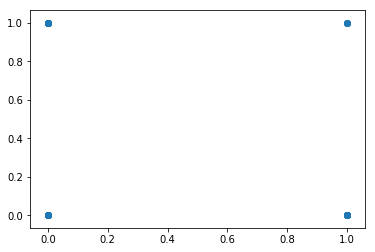

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


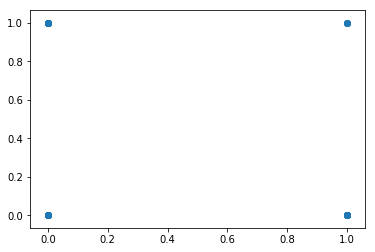

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


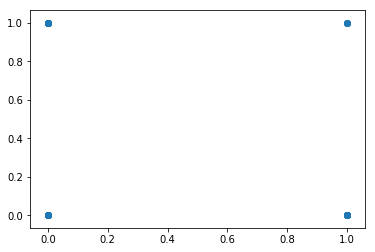

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


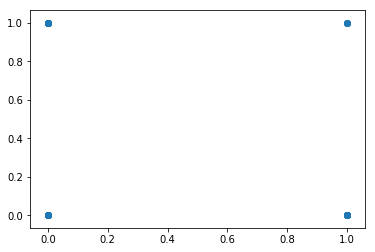

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


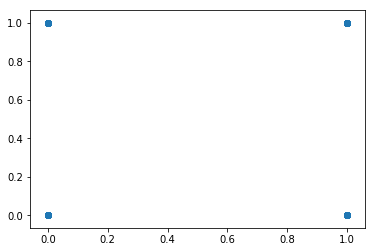

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


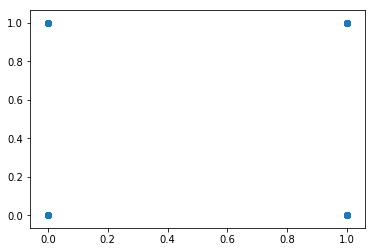

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


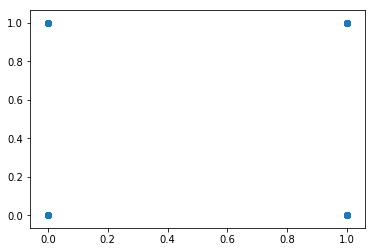

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


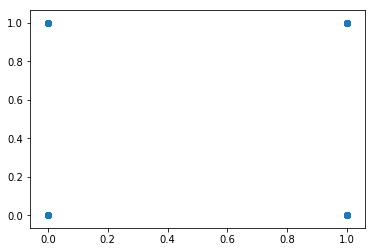

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


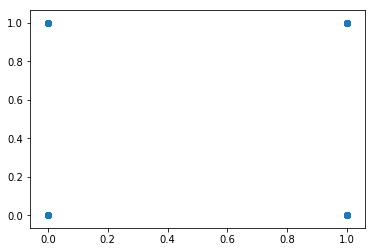

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


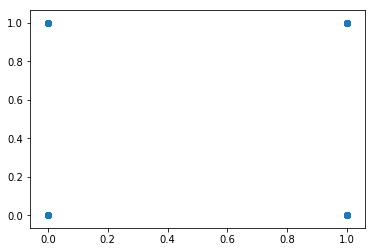

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


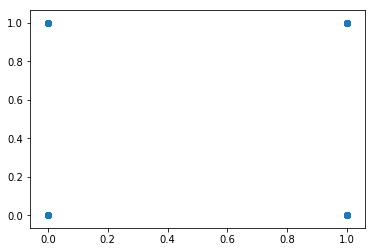

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


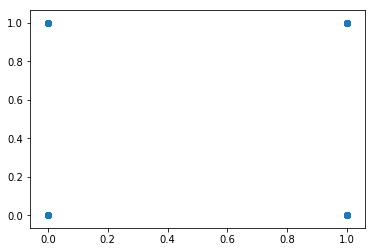

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


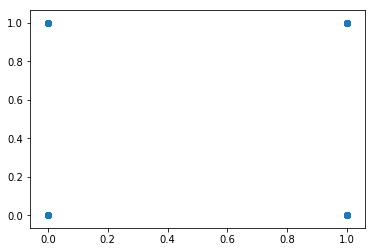

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


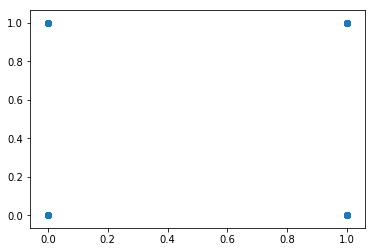

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


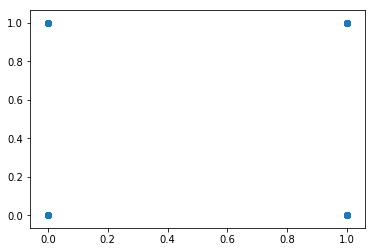

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


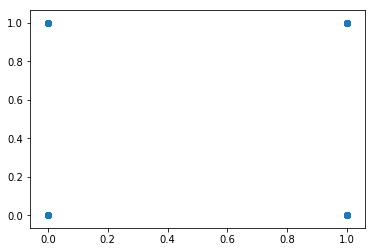

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


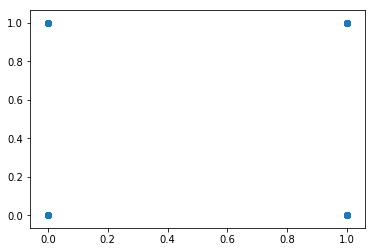

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


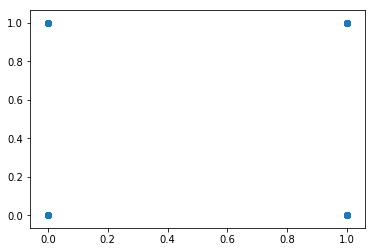

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


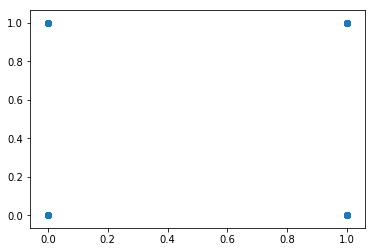

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


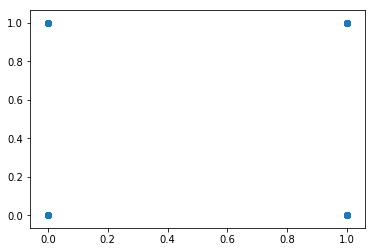

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


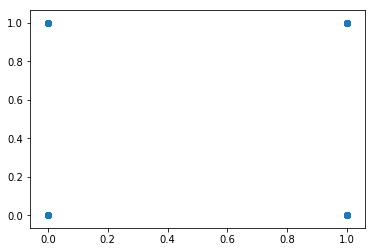

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


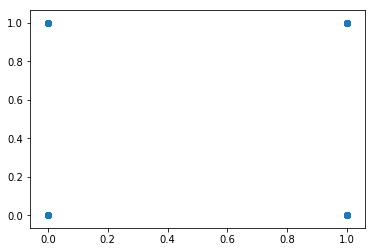

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


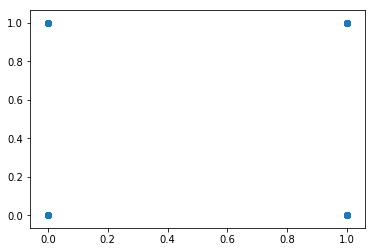

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


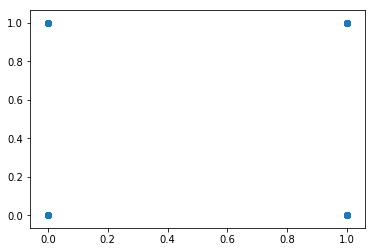

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


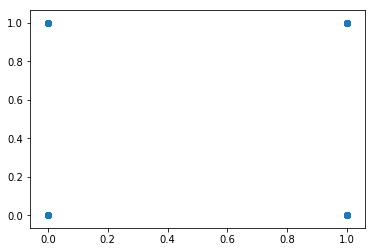

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


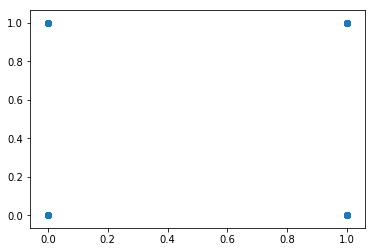

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


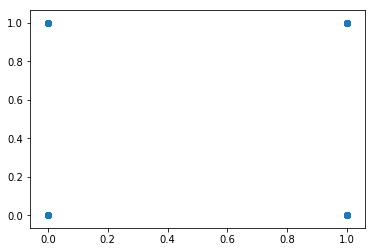

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


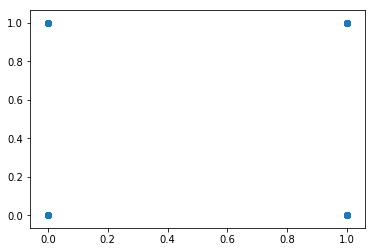

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


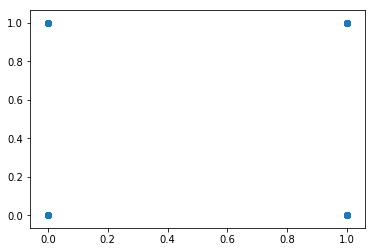

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


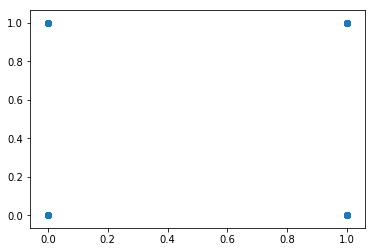

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


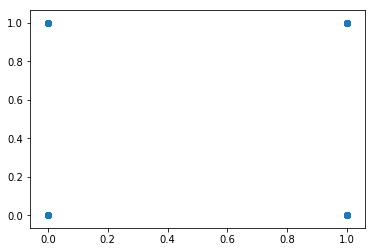

[0 1 0 ..., 0 1 0] [0 0 0 ..., 1 1 1]


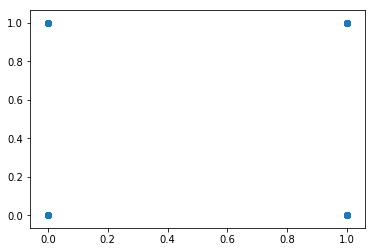

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


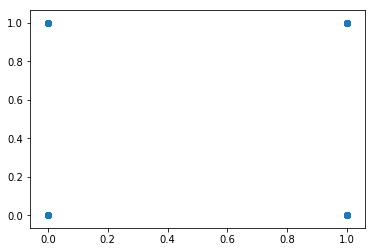

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


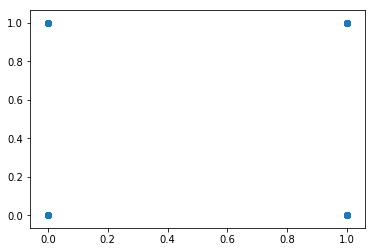

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


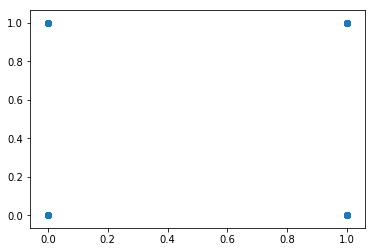

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


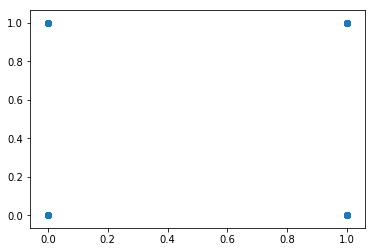

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


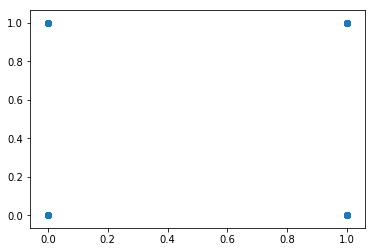

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


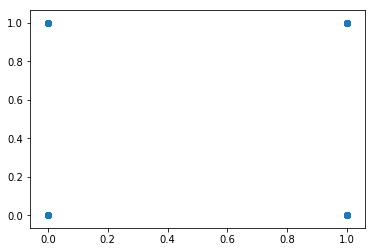

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


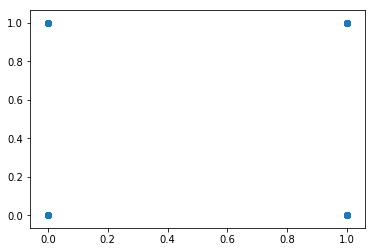

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


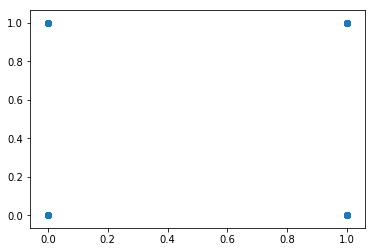

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


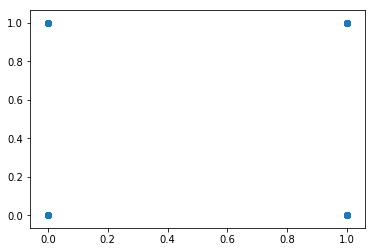

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


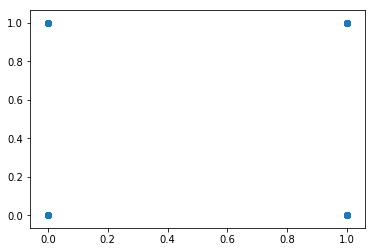

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


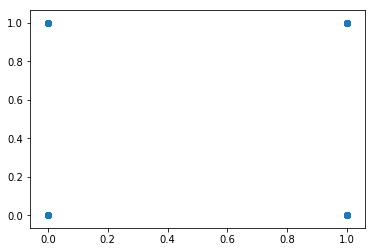

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


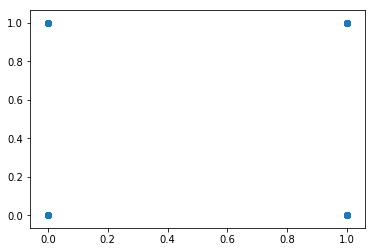

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


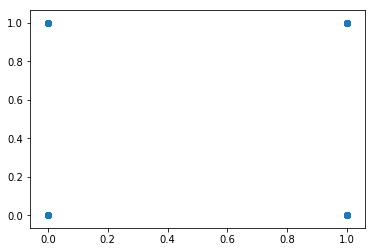

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


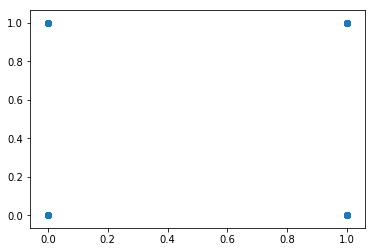

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


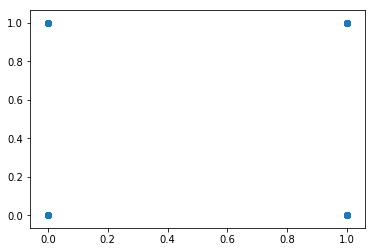

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


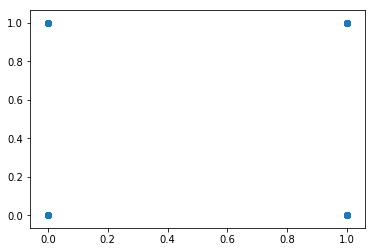

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


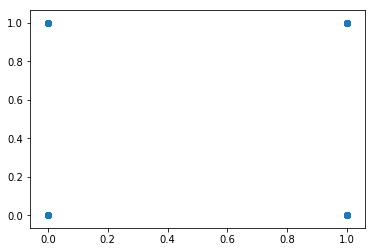

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


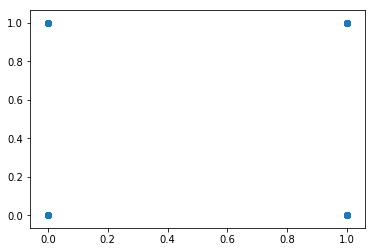

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


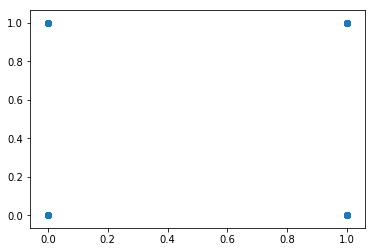

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


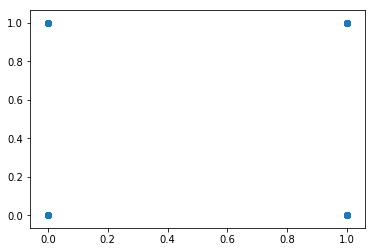

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


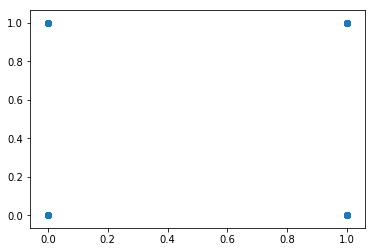

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


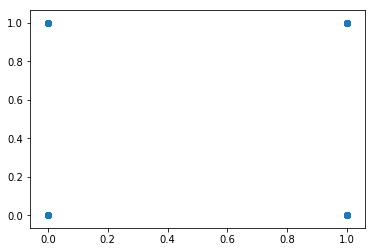

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


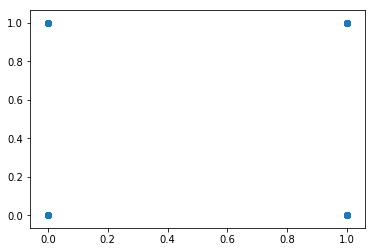

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


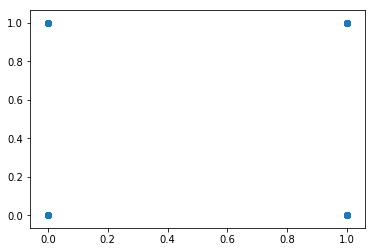

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


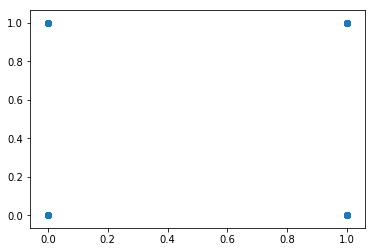

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


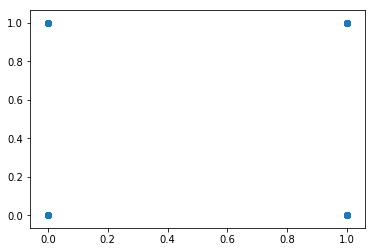

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


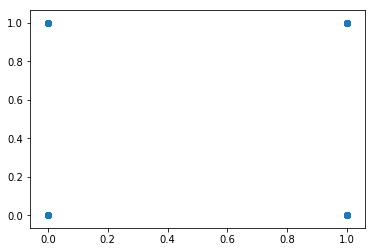

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


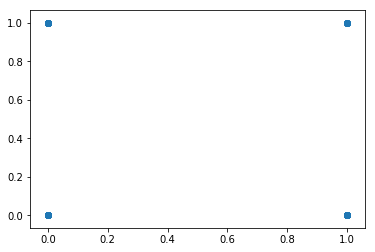

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


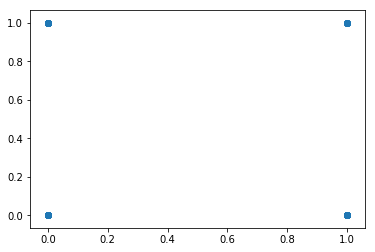

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


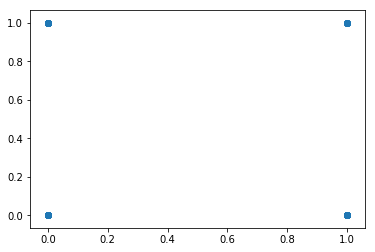

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


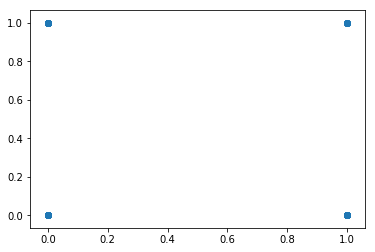

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


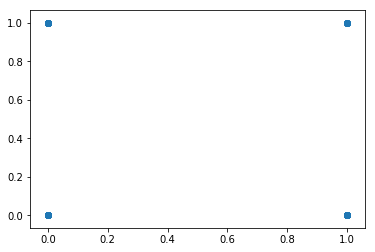

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


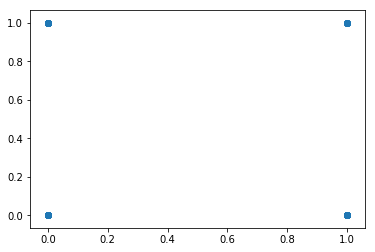

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


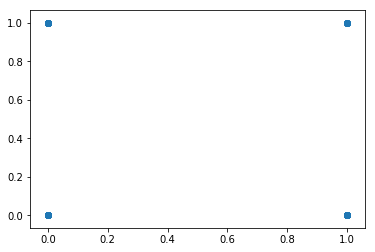

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


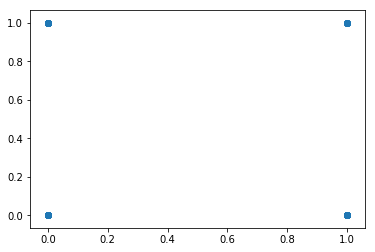

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


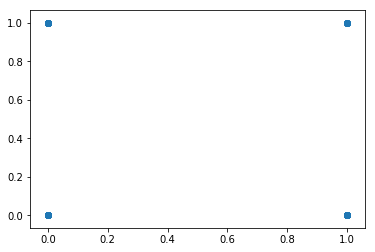

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


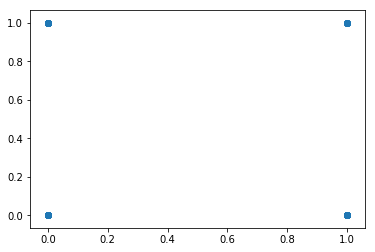

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


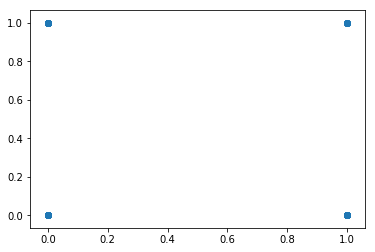

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


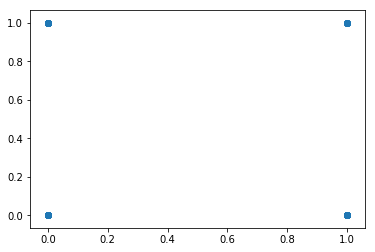

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


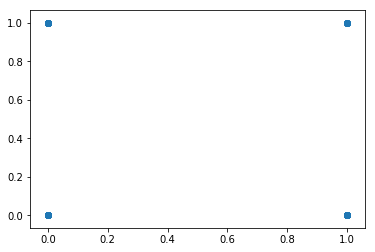

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


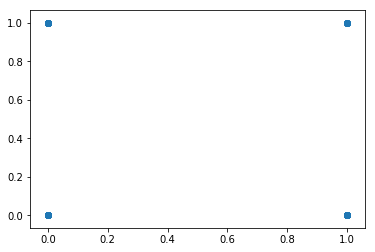

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


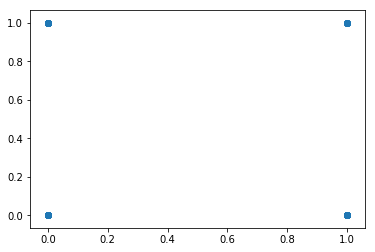

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


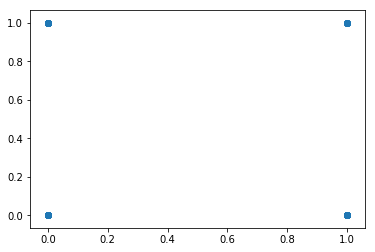

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


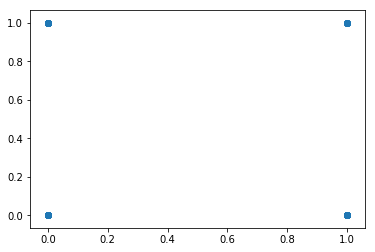

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


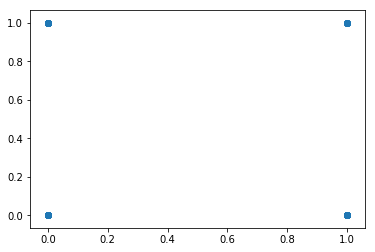

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


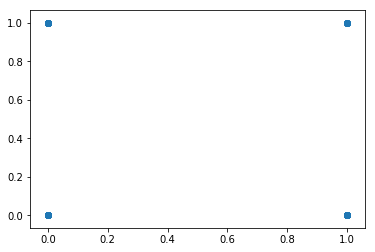

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


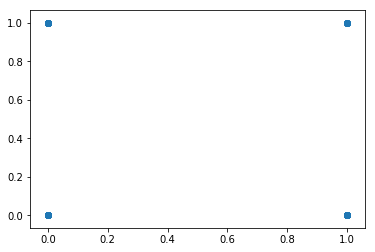

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


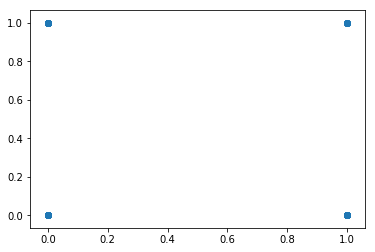

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


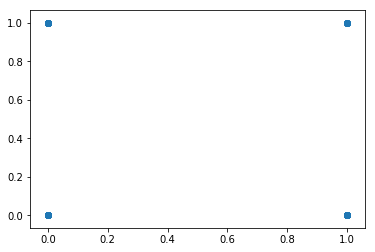

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


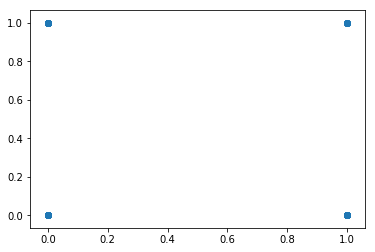

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


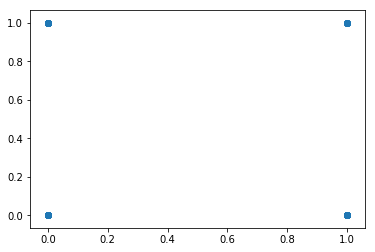

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


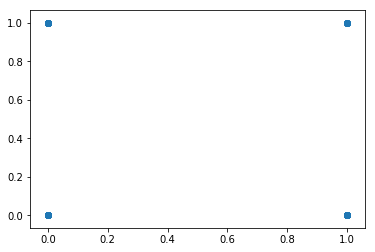

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


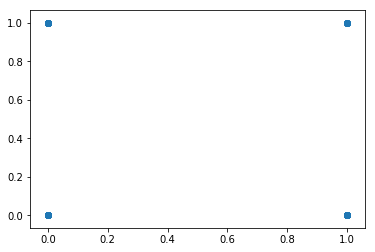

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


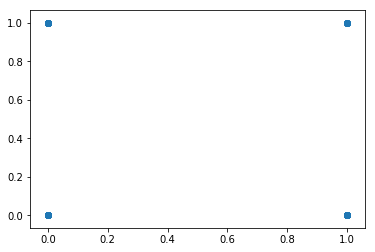

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


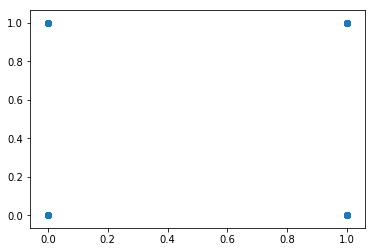

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


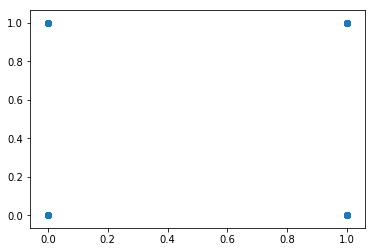

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


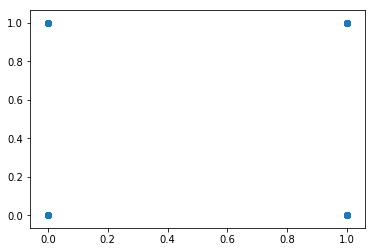

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


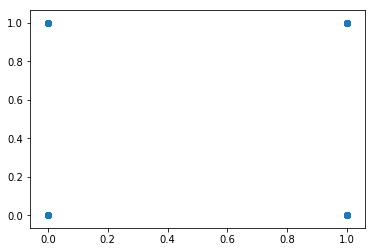

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


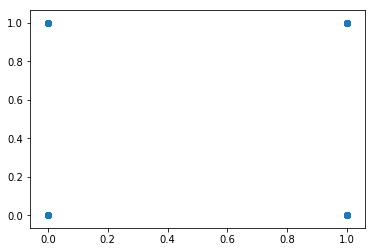

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


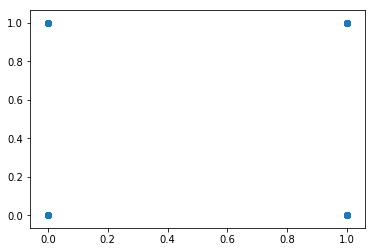

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


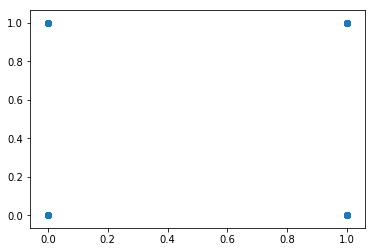

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


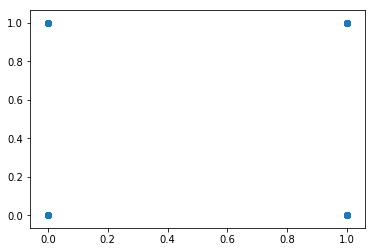

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


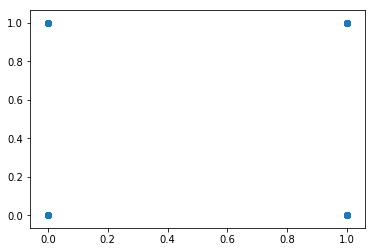

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


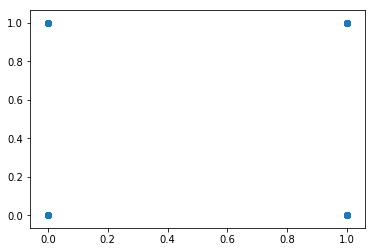

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


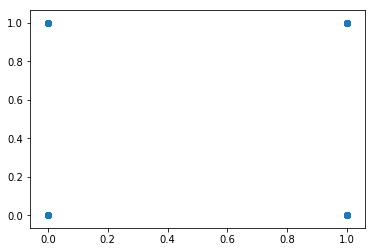

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


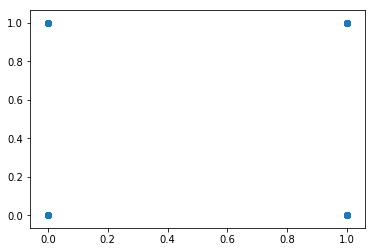

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


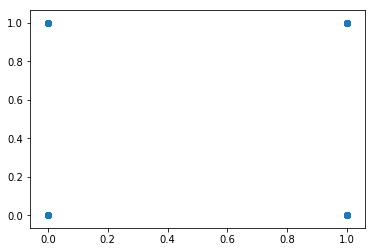

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


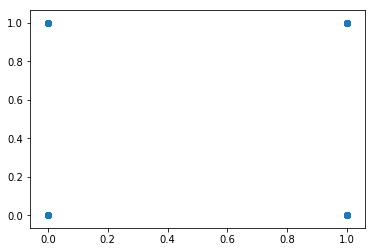

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


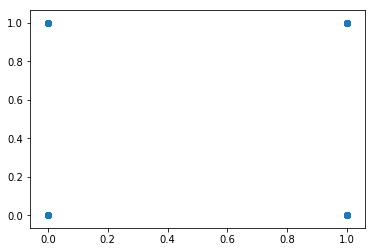

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


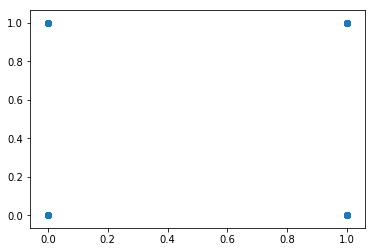

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


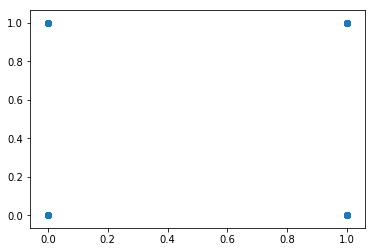

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


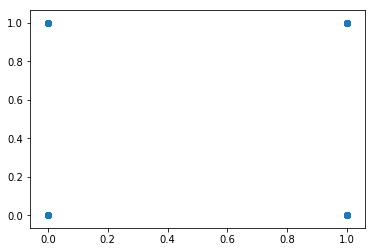

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


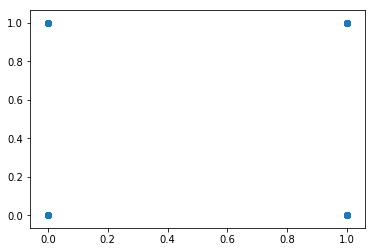

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


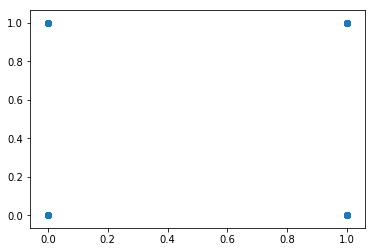

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


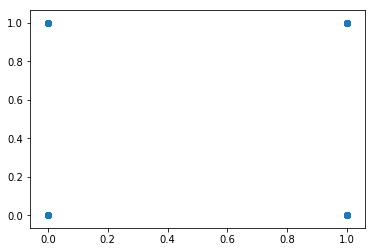

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


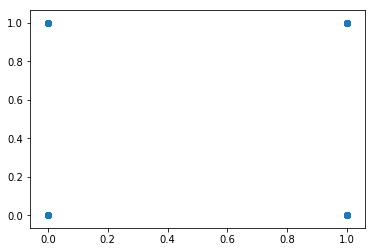

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


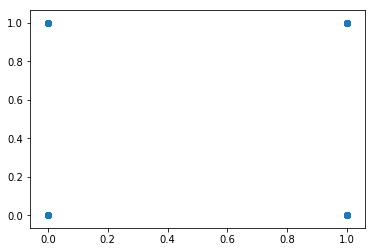

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


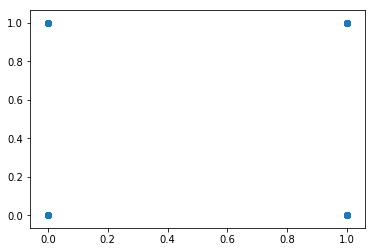

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


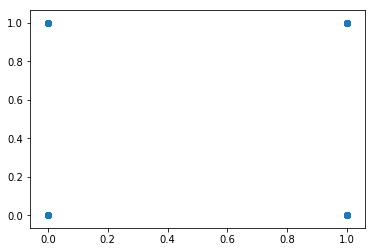

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


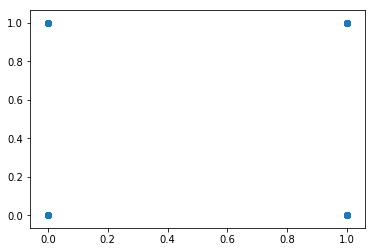

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


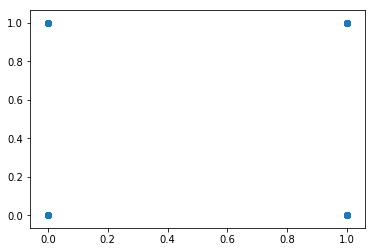

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


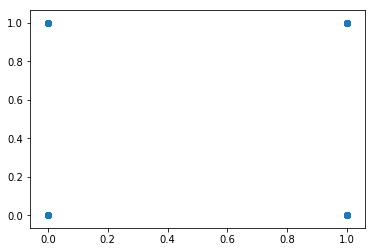

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


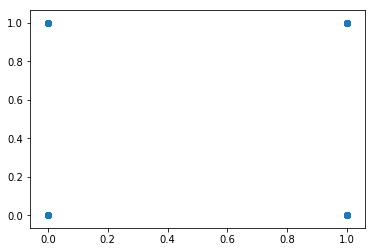

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


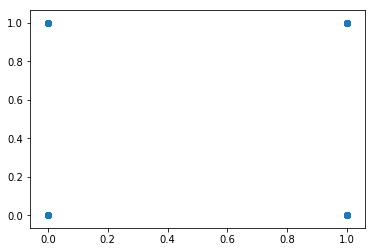

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


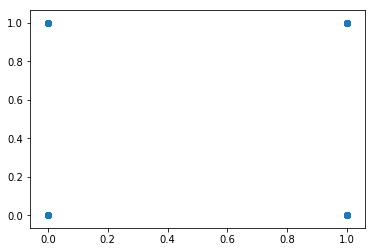

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


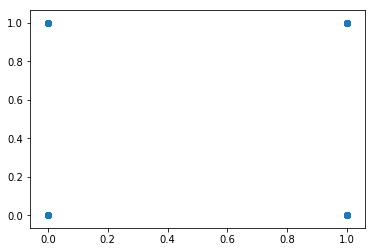

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


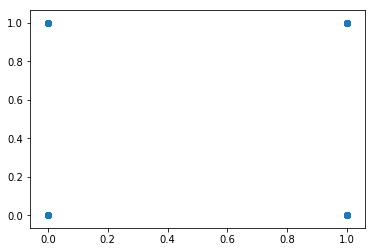

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


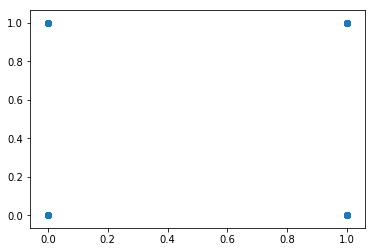

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


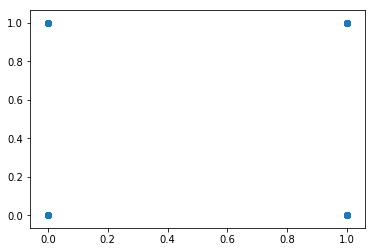

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


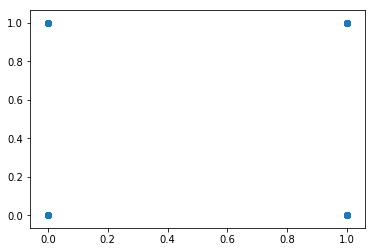

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


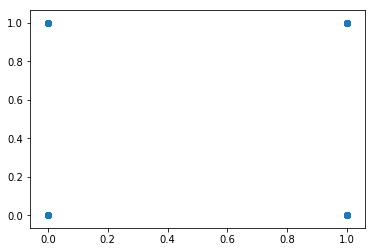

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


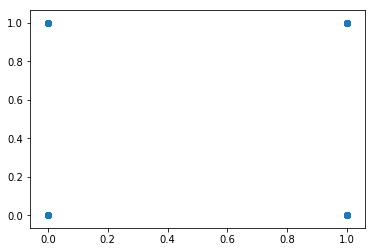

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


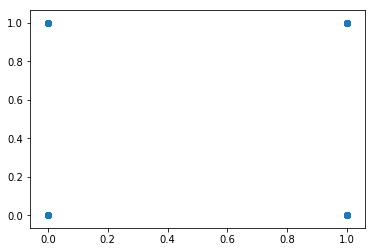

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


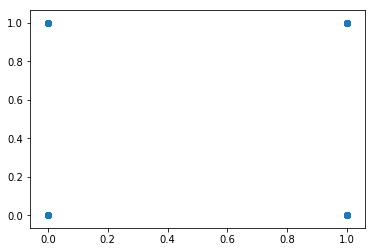

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


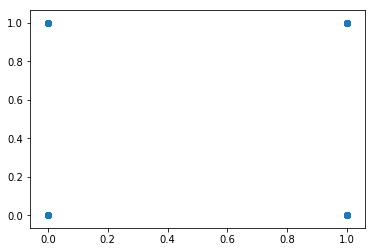

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


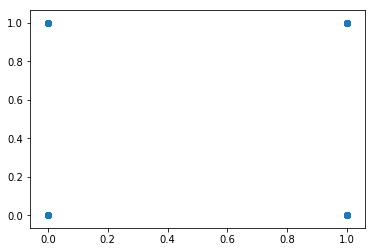

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


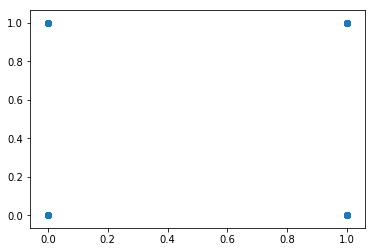

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


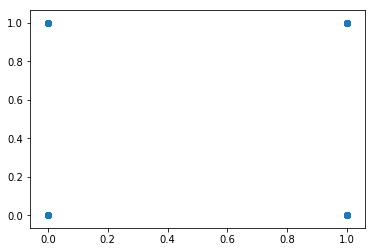

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


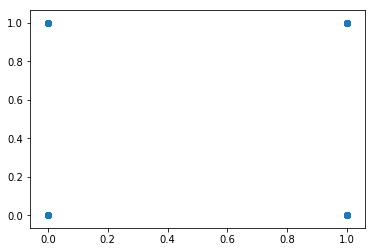

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


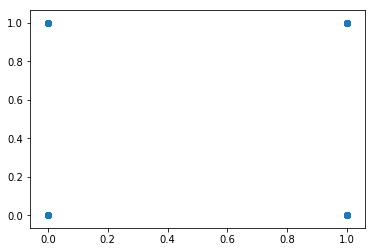

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


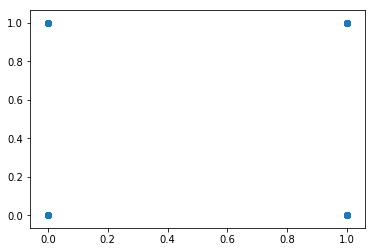

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


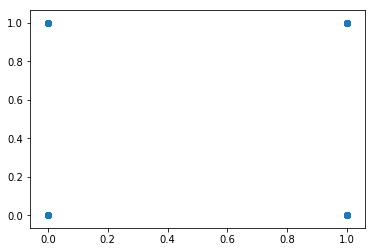

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


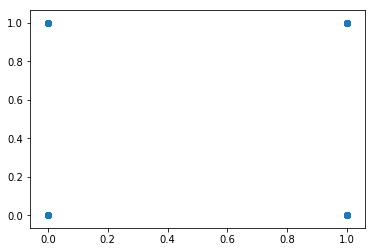

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


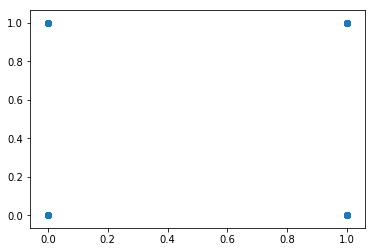

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


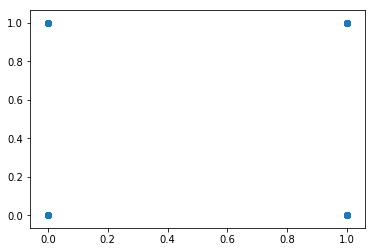

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


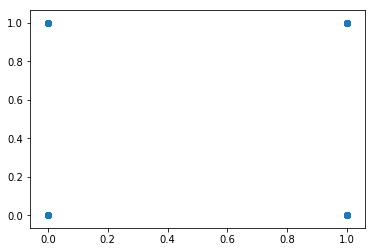

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


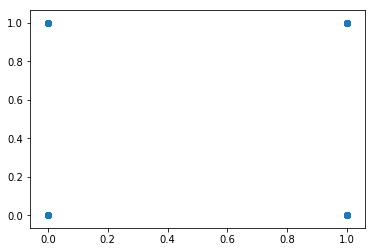

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


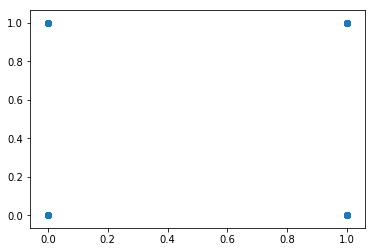

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


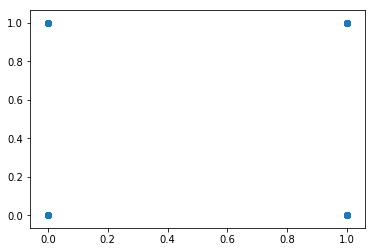

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


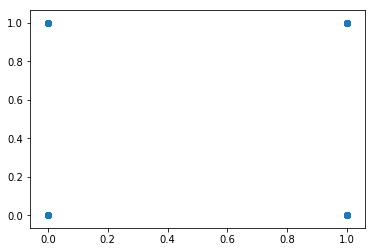

[1 0 1 ..., 0 0 0] [0 0 0 ..., 1 1 1]


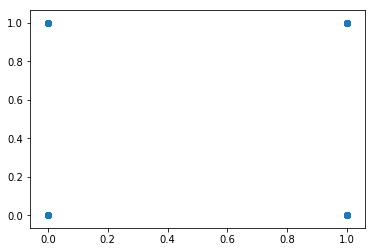

[1 0 1 ..., 0 0 0] [0 0 0 ..., 1 1 1]


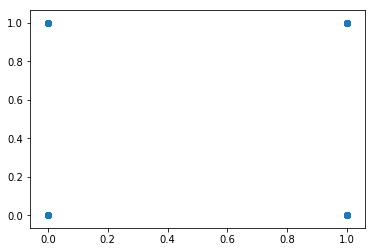

[1 0 1 ..., 0 0 0] [0 0 0 ..., 1 1 1]


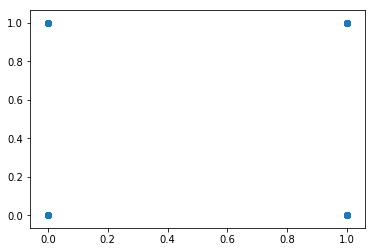

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


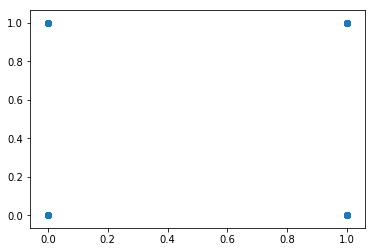

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


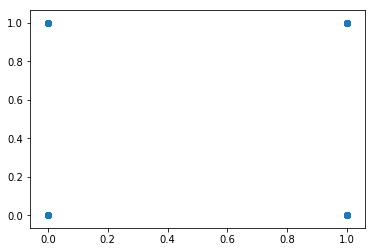

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


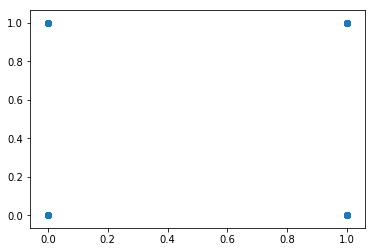

[1 0 1 ..., 1 0 0] [0 0 0 ..., 1 1 1]


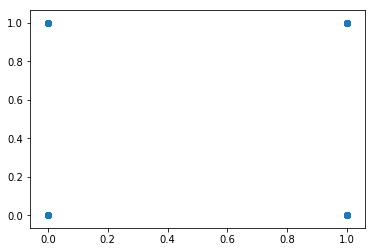

[0 0 0 ..., 1 0 0] [0 0 0 ..., 1 1 1]


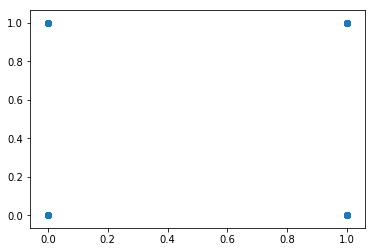

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


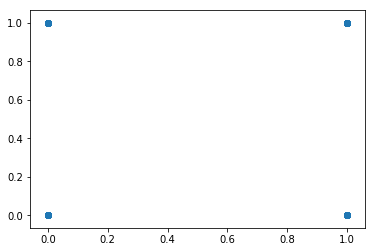

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


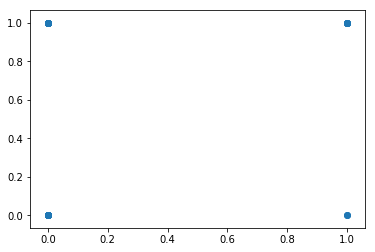

[0 0 0 ..., 1 0 0] [0 0 0 ..., 1 1 1]


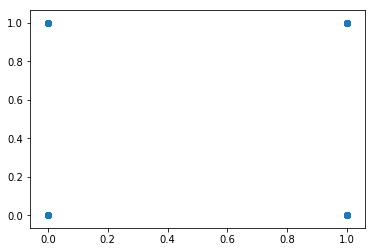

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


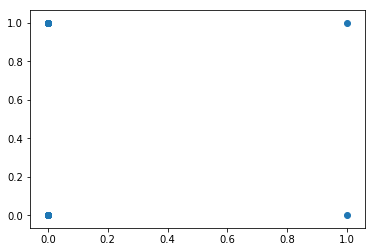

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


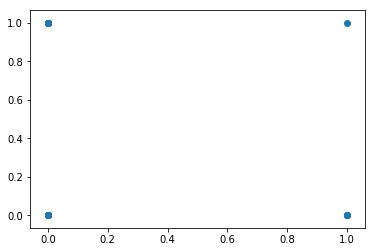

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


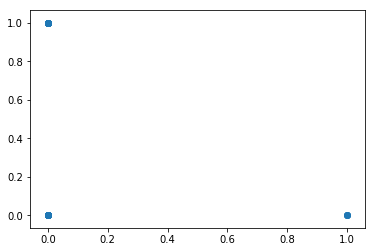

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


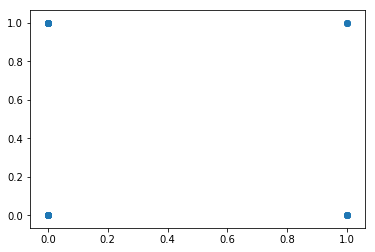

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


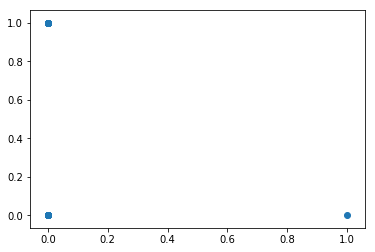

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


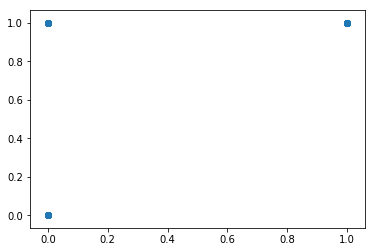

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


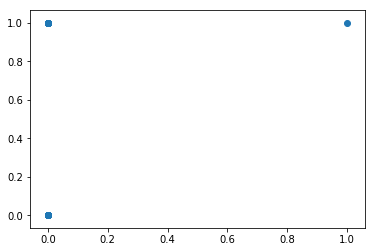

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


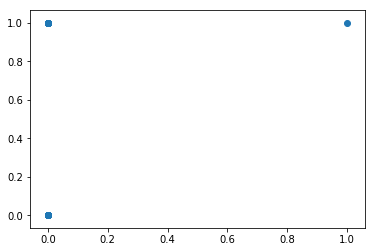

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


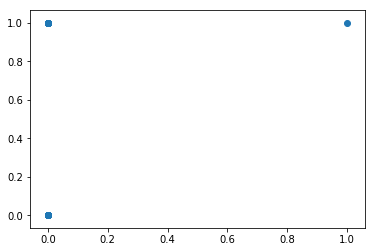

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


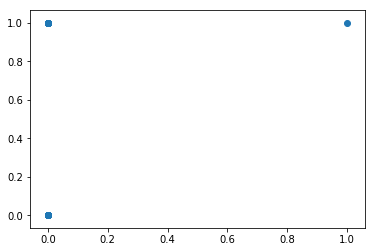

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


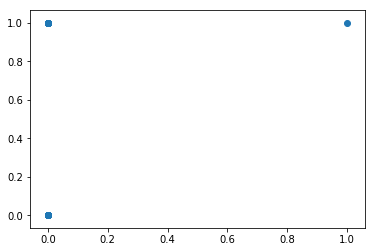

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


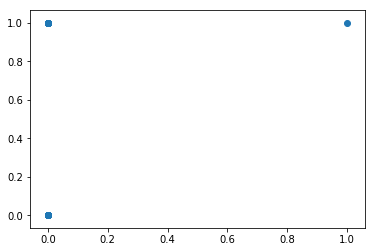

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


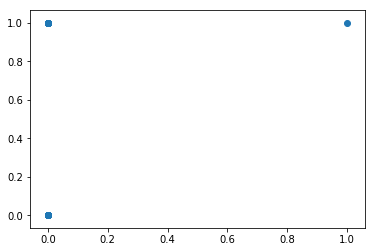

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


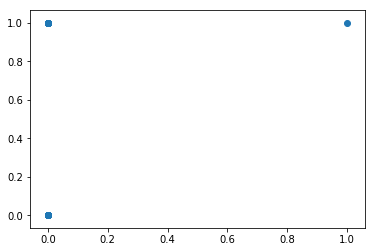

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


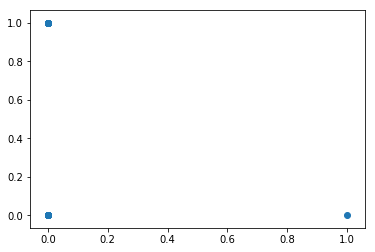

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


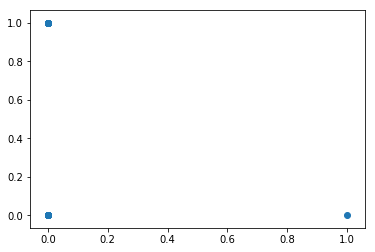

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


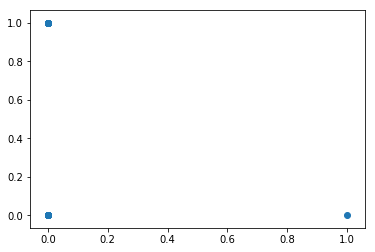

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


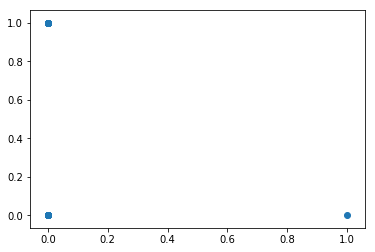

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


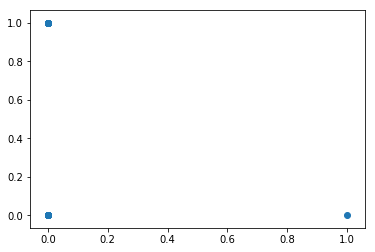

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


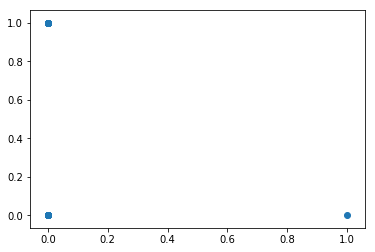

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


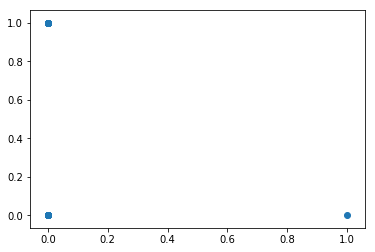

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


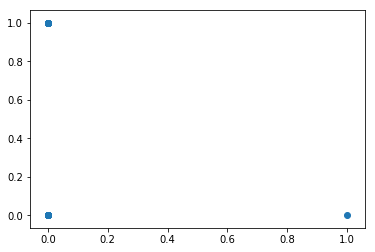

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


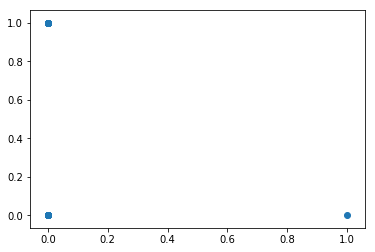

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


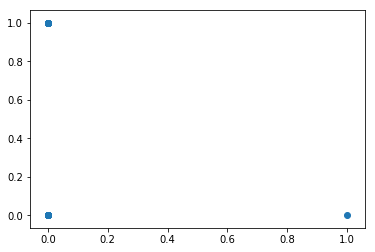

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


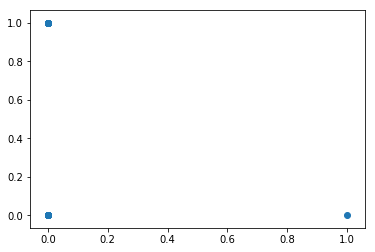

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


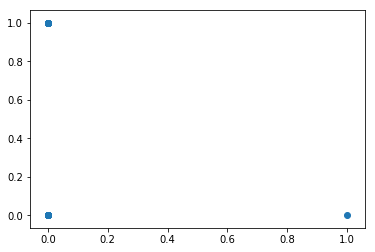

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


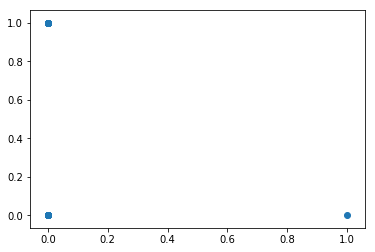

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


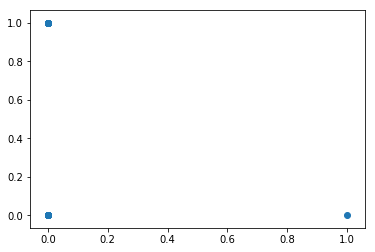

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


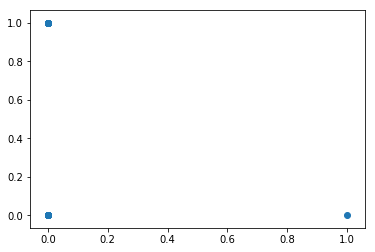

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


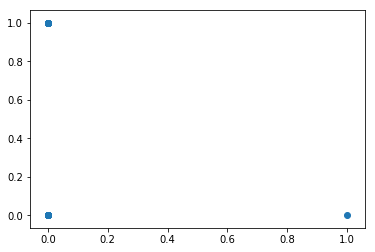

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


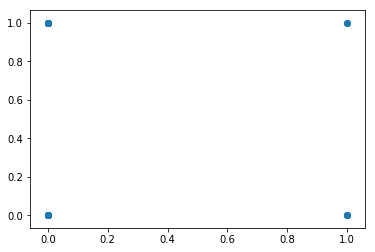

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


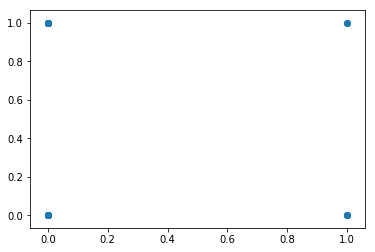

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


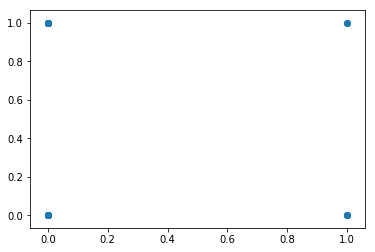

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


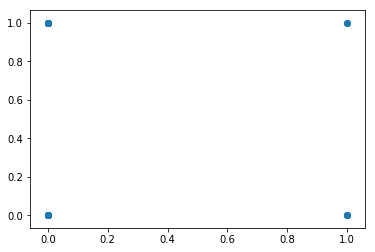

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


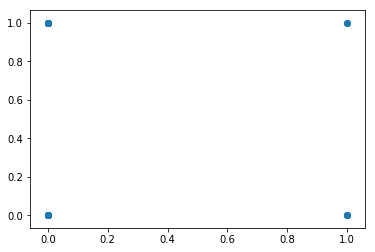

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


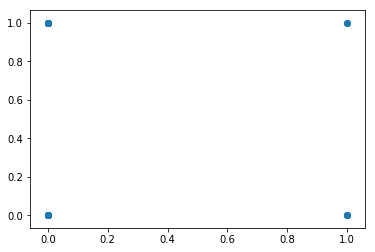

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


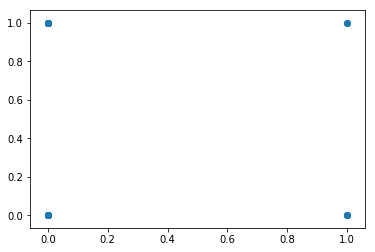

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


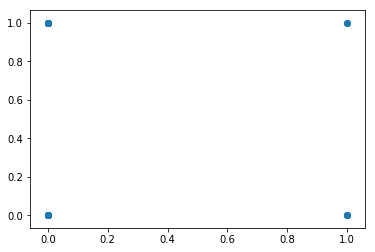

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


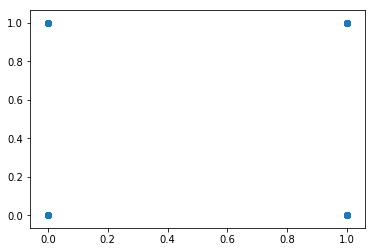

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


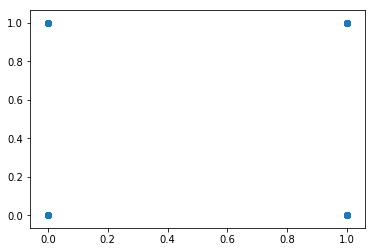

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


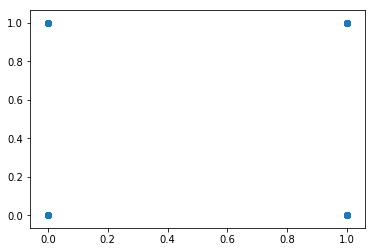

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


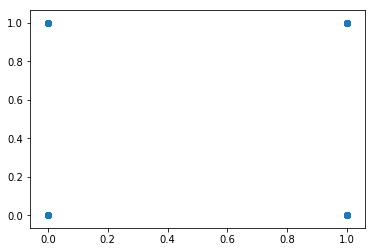

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


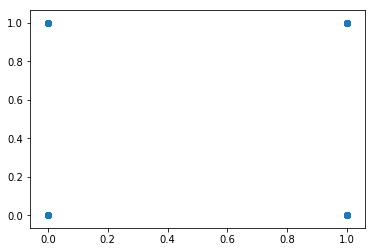

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


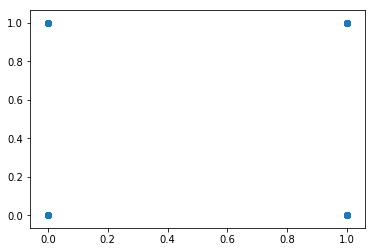

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


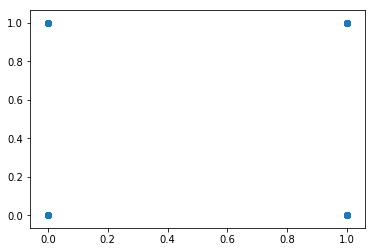

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


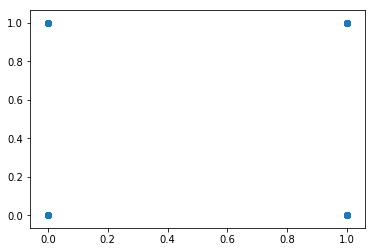

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


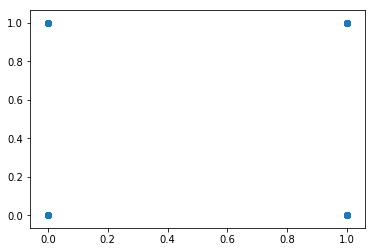

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


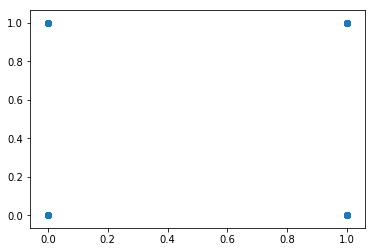

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


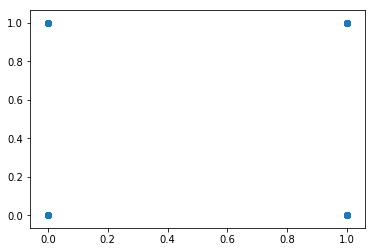

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


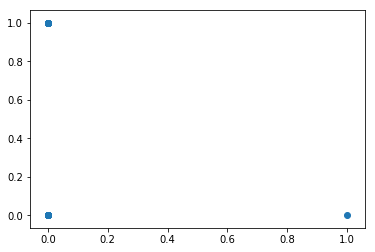

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


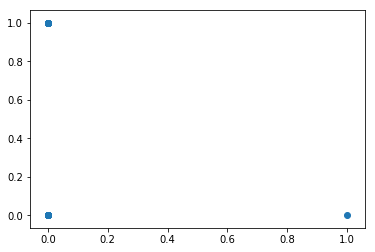

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


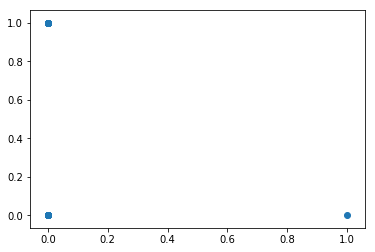

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


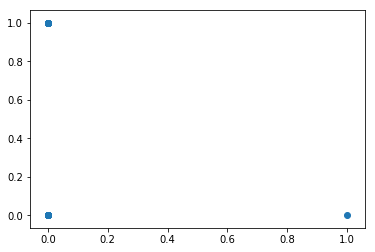

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


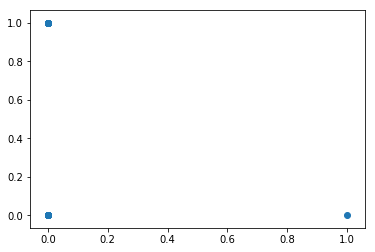

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


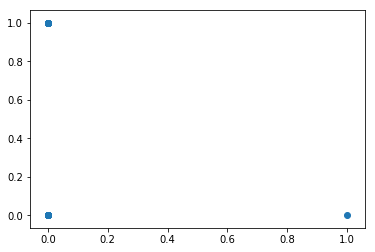

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


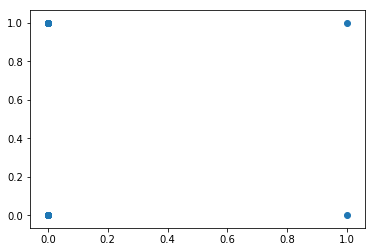

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


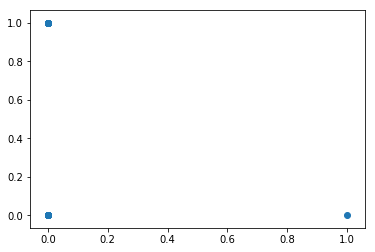

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


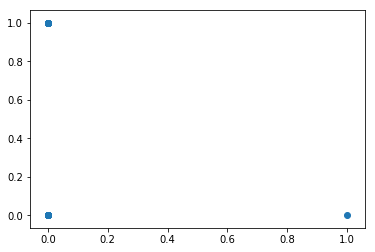

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


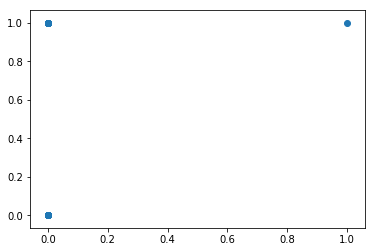

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


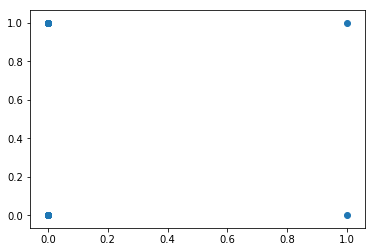

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


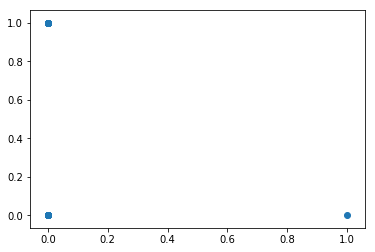

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


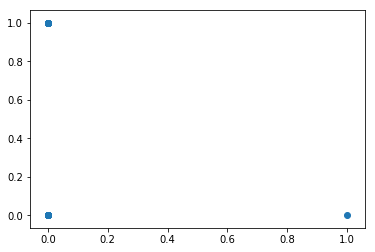

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


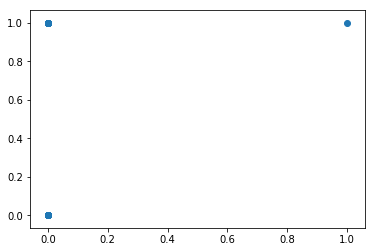

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


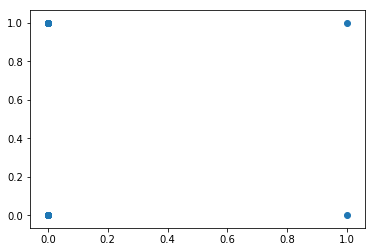

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


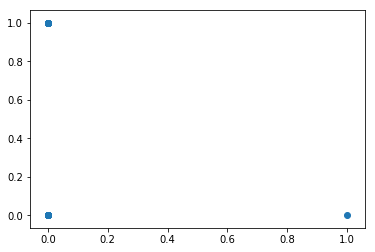

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


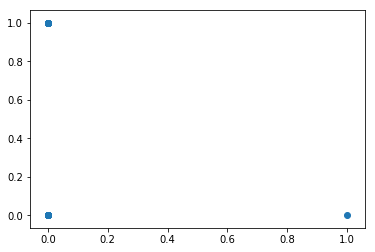

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


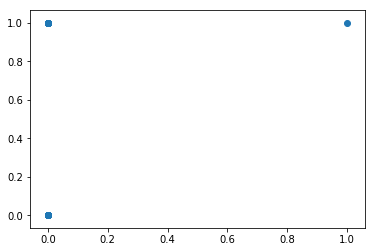

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


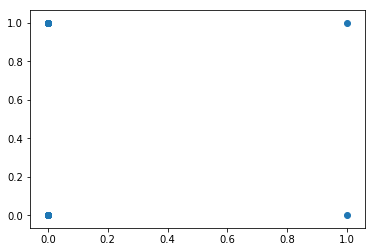

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


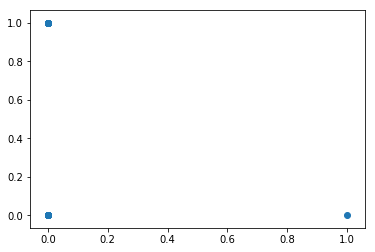

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


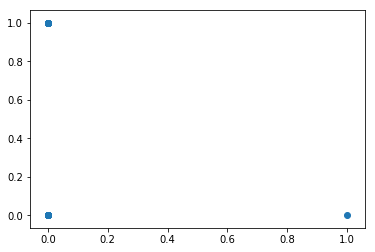

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


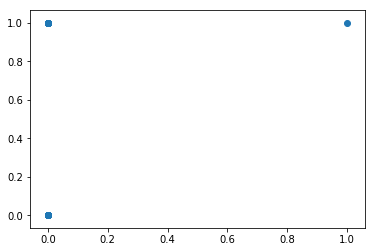

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


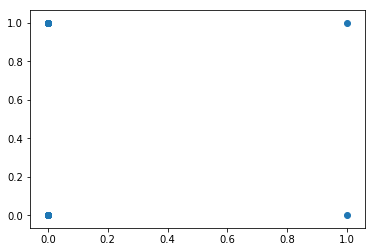

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


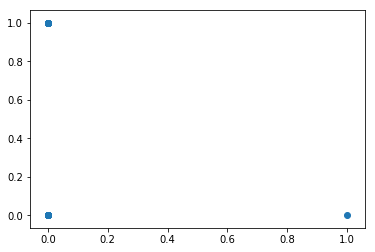

[0 0 0 ..., 0 0 0] [0 0 0 ..., 1 1 1]


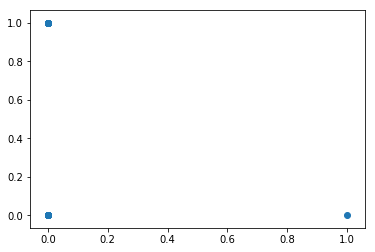

[0 0 0 ..., 0 0 1] [0 0 0 ..., 1 1 1]


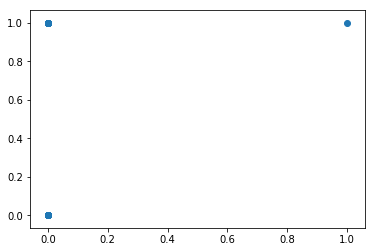

In [13]:
for column_name in df_cat_balance:
    print(df_cat_balance[column_name].values, df_cat_balance['Response'].values)
    plt.scatter(df_cat_balance[column_name].values, df_cat_balance['Response'].values)
    plt.show()


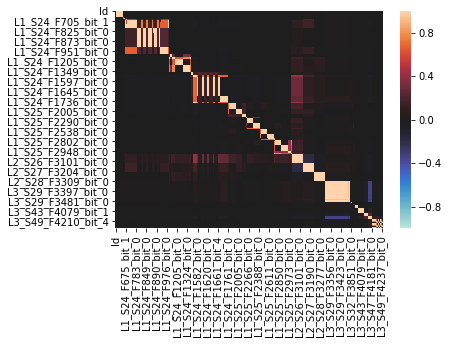

In [14]:
df_corr = df_cat_balance.corr()
sns.heatmap(df_corr, vmax=1, vmin=-1, center=0)

In [15]:
duplicate_list = []
for column_name_1 in df_cat_balance:
    for column_name_2 in df_cat_balance:
        if column_name_1 != column_name_2:
            if np.allclose(df_cat_balance[column_name_1].values, df_cat_balance[column_name_2].values):
                duplicate_list.append(column_name_1)

print(duplicate_list)


['L0_S2_F33_bit_0', 'L0_S2_F33_bit_0', 'L0_S2_F33_bit_0', 'L0_S2_F33_bit_0', 'L0_S2_F33_bit_0', 'L0_S2_F33_bit_0', 'L0_S2_F33_bit_0', 'L0_S2_F33_bit_0', 'L0_S2_F33_bit_0', 'L0_S2_F33_bit_0', 'L0_S2_F33_bit_0', 'L0_S2_F33_bit_0', 'L0_S2_F33_bit_0', 'L0_S2_F33_bit_0', 'L0_S2_F33_bit_0', 'L0_S2_F33_bit_0', 'L0_S2_F33_bit_0', 'L0_S2_F35_bit_5', 'L0_S2_F35_bit_5', 'L0_S2_F35_bit_5', 'L0_S2_F35_bit_5', 'L0_S2_F35_bit_5', 'L0_S2_F35_bit_5', 'L0_S2_F35_bit_5', 'L0_S2_F35_bit_5', 'L0_S2_F35_bit_5', 'L0_S2_F35_bit_5', 'L0_S2_F35_bit_5', 'L0_S2_F35_bit_5', 'L0_S2_F35_bit_5', 'L0_S2_F35_bit_5', 'L0_S2_F35_bit_5', 'L0_S2_F35_bit_5', 'L0_S2_F35_bit_5', 'L0_S2_F37_bit_0', 'L0_S2_F37_bit_0', 'L0_S2_F37_bit_0', 'L0_S2_F37_bit_0', 'L0_S2_F37_bit_0', 'L0_S2_F37_bit_0', 'L0_S2_F37_bit_0', 'L0_S2_F37_bit_0', 'L0_S2_F37_bit_0', 'L0_S2_F37_bit_0', 'L0_S2_F37_bit_0', 'L0_S2_F37_bit_0', 'L0_S2_F37_bit_0', 'L0_S2_F37_bit_0', 'L0_S2_F37_bit_0', 'L0_S2_F37_bit_0', 'L0_S2_F37_bit_0', 'L0_S2_F39_bit_5', 'L0_S2_F39_